<a href="https://colab.research.google.com/github/tommyEzreal/study_low_level/blob/main/NLP/transformer_from_scratch_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code from https://www.youtube.com/watch?v=U0s0f995w14:

In [ ]:
import torch
torch.__version__



'1.13.1+cu116'

In [ ]:
import spacy
import soynlp

print(spacy.__version__)
print(soynlp.__version__)

3.4.4
0.0.493


In [ ]:
! pip install soynlp
! pip install torchtext==0.6.0
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-02-16 11:17:38.145114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 11:17:39.659089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 11:17:39.659235: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

In [ ]:
import torch
import torch.nn as nn
import math

In [ ]:
!nvidia-smi

Wed Feb 15 18:03:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Multi Head Attention

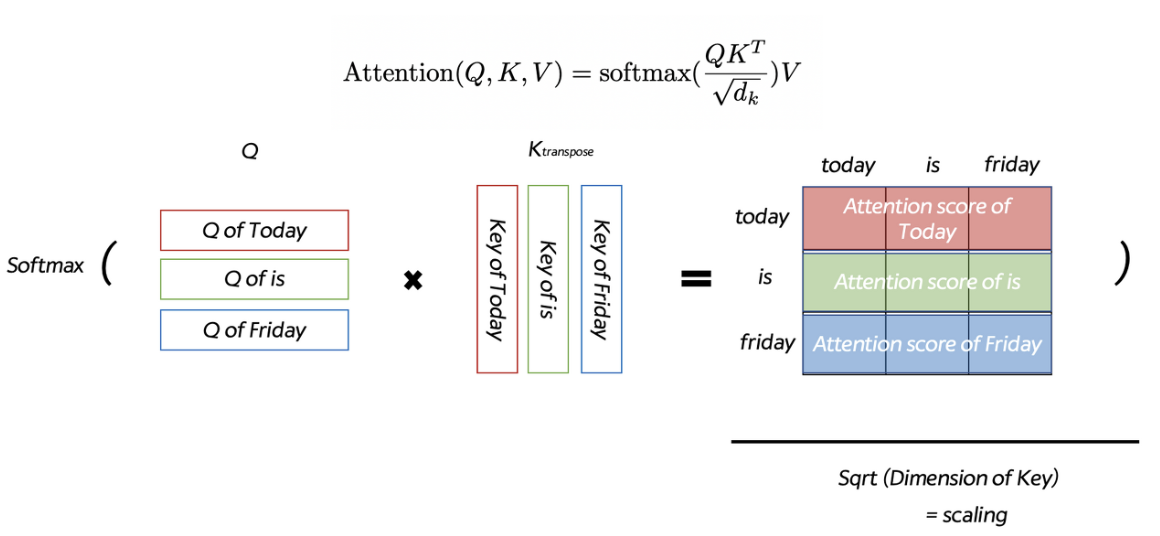

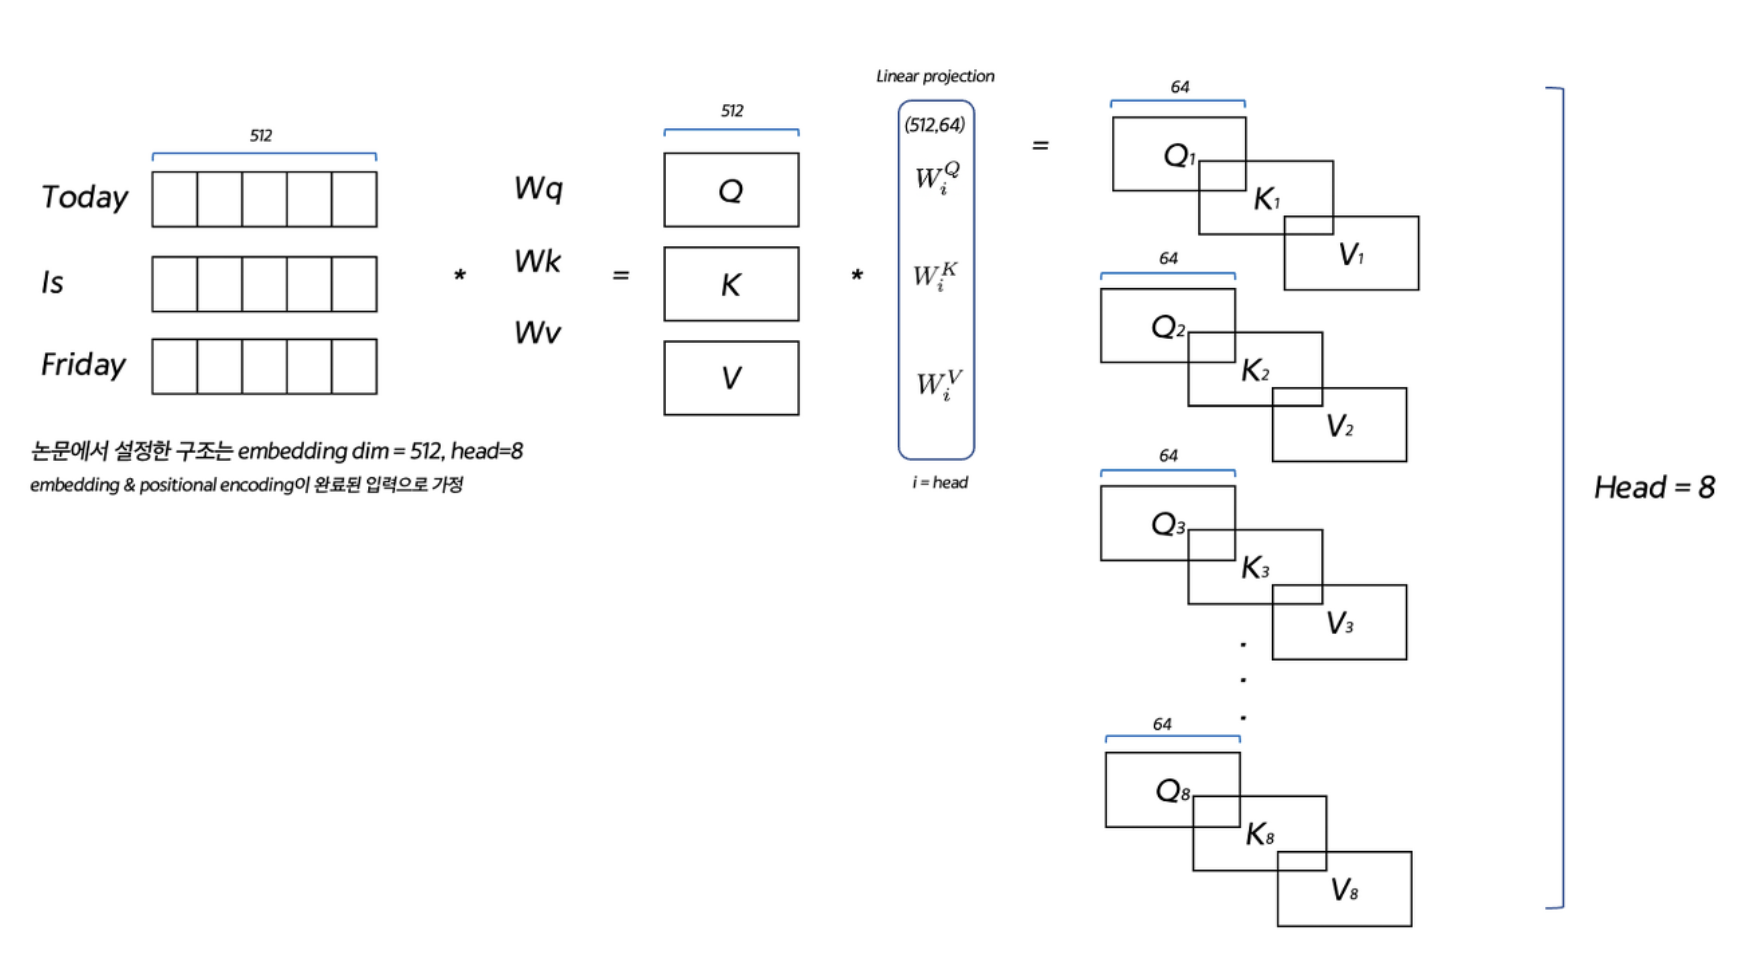

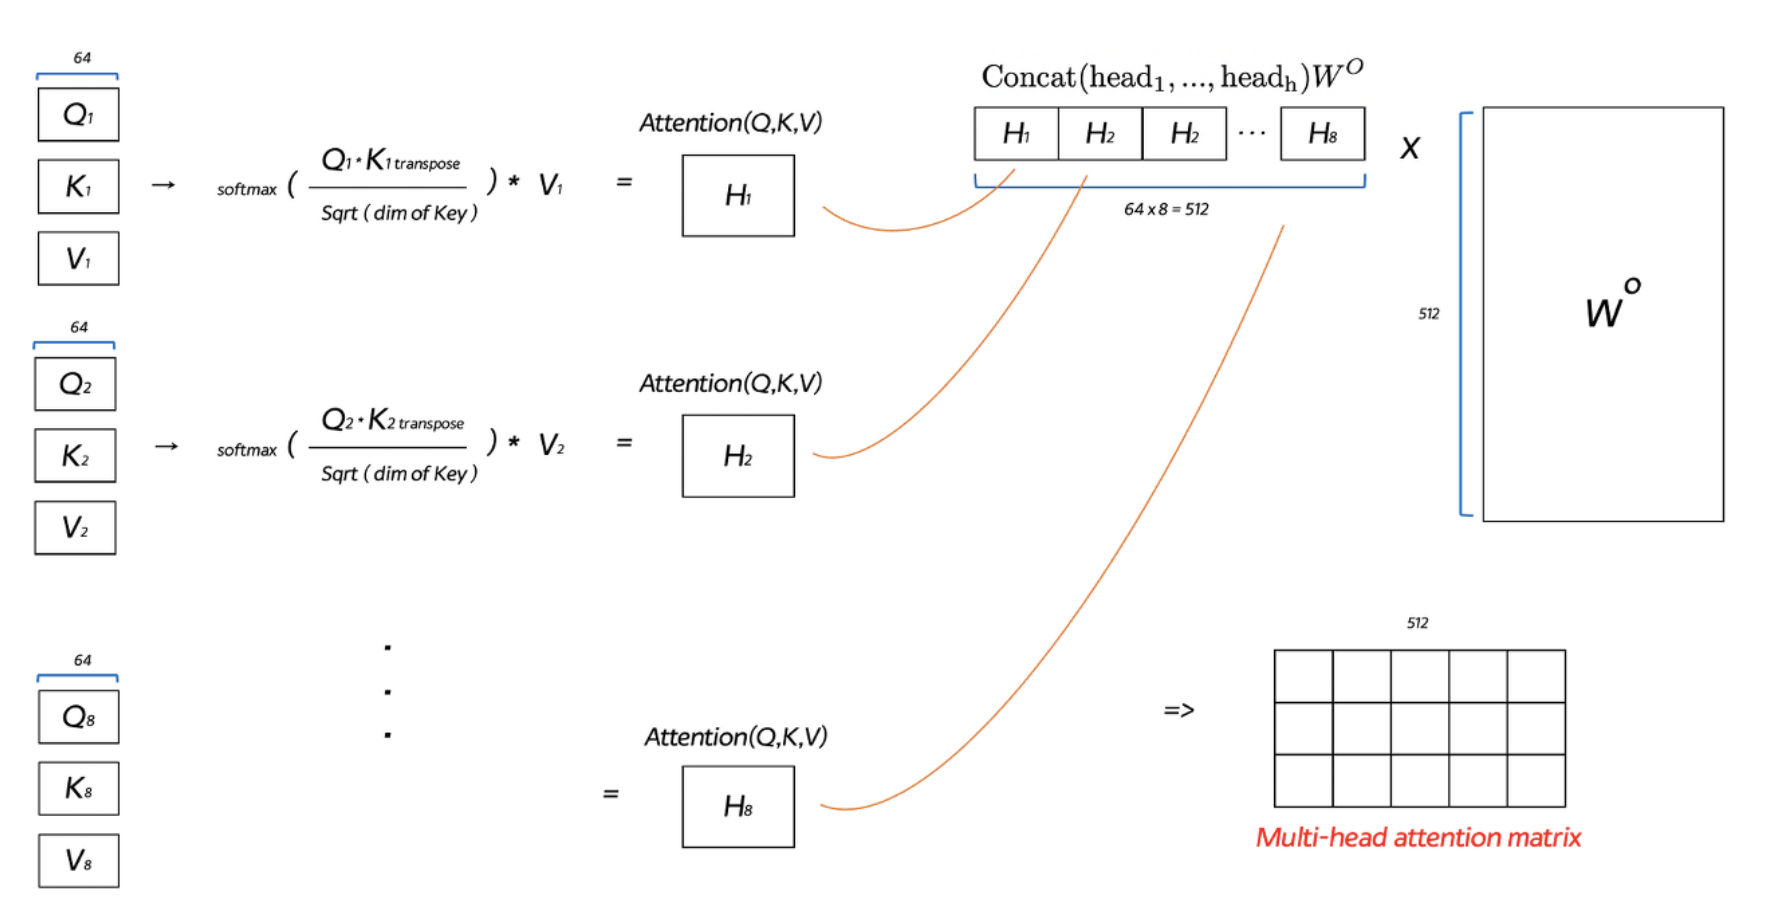

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_size, heads, dropout=0.1): 
    # embed_size = d_model, heads = num_heads , head_dim = d_k
    super(MultiHeadAttention,self).__init__()

    self.embed_size = embed_size # d_model  (임베딩차원 , hidden_dim)
    self.heads = heads # num_heads
    self.head_dim = embed_size // heads # dim of each head 
    assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

    self.fc_queries = nn.Linear(embed_size, embed_size) # fc layer of Query
    self.fc_keys = nn.Linear(embed_size, embed_size) # fc Key
    self.fc_values = nn.Linear(embed_size, embed_size) # fc Value

    self.dropout = nn.Dropout(dropout)
    self.fc_out = nn.Linear(embed_size, embed_size)

  def forward(self, query, key, value, mask=None):
    N = query.shape[0] # N = batch

    # query = [batch_size, query_len, embed_size]
    # key = [batch_size, key_len, embed_size]
    # value = [batch_size, value_len, embed_size]

    # head개수만큼 나눠주기 (num_heads만큼의 K,Q,V)
    # view: [batch, qkv_len, embed_size] -> [batch, qkvlen, n_heads, head_dim]
    query = self.fc_queries(query).view(N , -1, self.heads, self.head_dim)
    key = self.fc_keys(key).view(N, -1, self.heads, self.head_dim)
    value = self.fc_values(value).view(N, -1, self.heads, self.head_dim)

    # = permute(0,2,1,3) = (batch(N), num_heads(self.heads), qkv_len, self.head_dim)
    query = query.transpose(1,2) # [batch, n_heads, query_len, head_dim]
    key = key.transpose(1,2) # [batch, n_heads, key_len, head_dim]
    value = value.transpose(1,2) # [batch, n_heads, value_len, head_dim]


    # dot_product attention calculate
    scaled_dp_attn = self.dot_product_attention(query, key, value, self.head_dim, mask, self.dropout)
    # scaled_dot_product_attention : [batch, n_heads, q_len, head_dim]

    concat = scaled_dp_attn.transpose(1,2).contiguous() # [batch, q_len, n_heads, head_dim]
    concat = concat.view(N, -1, self.embed_size) # 다시 embedsize로 concat [batch, q_len, n_heads*head_dim]
    out = self.fc_out(concat) # fc layer in 

    return out # [batch_size, query_len, embed_size]

  # 내적연산부분 따로 정의 
  def dot_product_attention(self, query, key, value, head_dim, mask=None, dropout=None):
    energy = torch.matmul(query, key.transpose(-2,-1) / math.sqrt(self.head_dim)) # attn energy
    # key.tanspose(-2,-1): [batch, n_heads, key_len, head_dim] -> [batch, n_heads, head_dim, key_len]
    # torch.matmul(q,k.transpose(-2,-1)) : [b,n_h,q_len,h_d] * [b,n_h,h_d,k_len] = [b, n_h, q_len, k_len]
    # /math.sqrt(self.head_dim) = scaling with head_dim  before softmax

    if mask is not None: # mask (optional)
      energy = energy.masked_fill(mask==0, -1e20)

    attention = torch.nn.functional.softmax(energy, dim=-1) # attention score  
    # [batch, n_heads, q_len, k_len]

    if dropout is not None:
      attention = dropout(attention)

    # softamx(QKtrans/scale) dot value
    # softmax( [batch, n_heads, q_len, k_len] * [batch, n_heads, v_len, head_dim] )
    out = torch.matmul(attention, value) # out: [batch, n_heads, q_len, head_dim]
    return out # scaled_dot_product_attention


In [ ]:
# class SelfAttention(nn.Module):
#   def __init__(self, embed_size, heads):
#     super(SelfAttention, self).__init__()
#     self.embed_size = embed_size
#     self.heads = heads
#     self.head_dim = embed_size // heads

#     assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

#     self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
#     self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
#     self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
#     self.fc_out = nn.Linear(heads * self.head_dim, embed_size) # =(embed_size, embed_size)

#   def forward(self, values, keys, query, mask):
#     N = query.shape[0]
#     value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

#     # split embedding into self.heads pieces

#     values = values.reshape(N, value_len, self.heads, self.head_dim)
#     keys = keys.reshape(N, key_len, self.heads, self.head_dim)
#     queries = query.reshape(N, query_len, self.heads, self.head_dim)

#     values = self.values(values)
#     keys = self.keys(keys)
#     queries = self.queries(queries)


#     """
#     # queries shape: (N, query_len, heads, heads_dim)
#     # keys shape: (N, key_len, heads, heads_dim)
#     # energy shape : (N, heads, query_len, key_len)
#     """
#     # einsum : instead of matmul 
#     energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

#     if mask is not None: # masking 
#       energy = energy.masked_fill(mask == 0, float("-1e20"))
    
#     """
#     attention shape : (N, heads, query_len, key_len)
#     values shape : (N, value_len, heads, heads_dim)
#     after einsum (N, query, heads, head_dim), flatten last two dim 
#     """
#     attention = torch.softmax(energy / self.embed_size ** (1/2), dim=3)
#     out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
#         N, query_len, self.heads * self.head_dim
#     )# concat

#     out = self.fc_out(out)
#     return out 
    

# Encoder

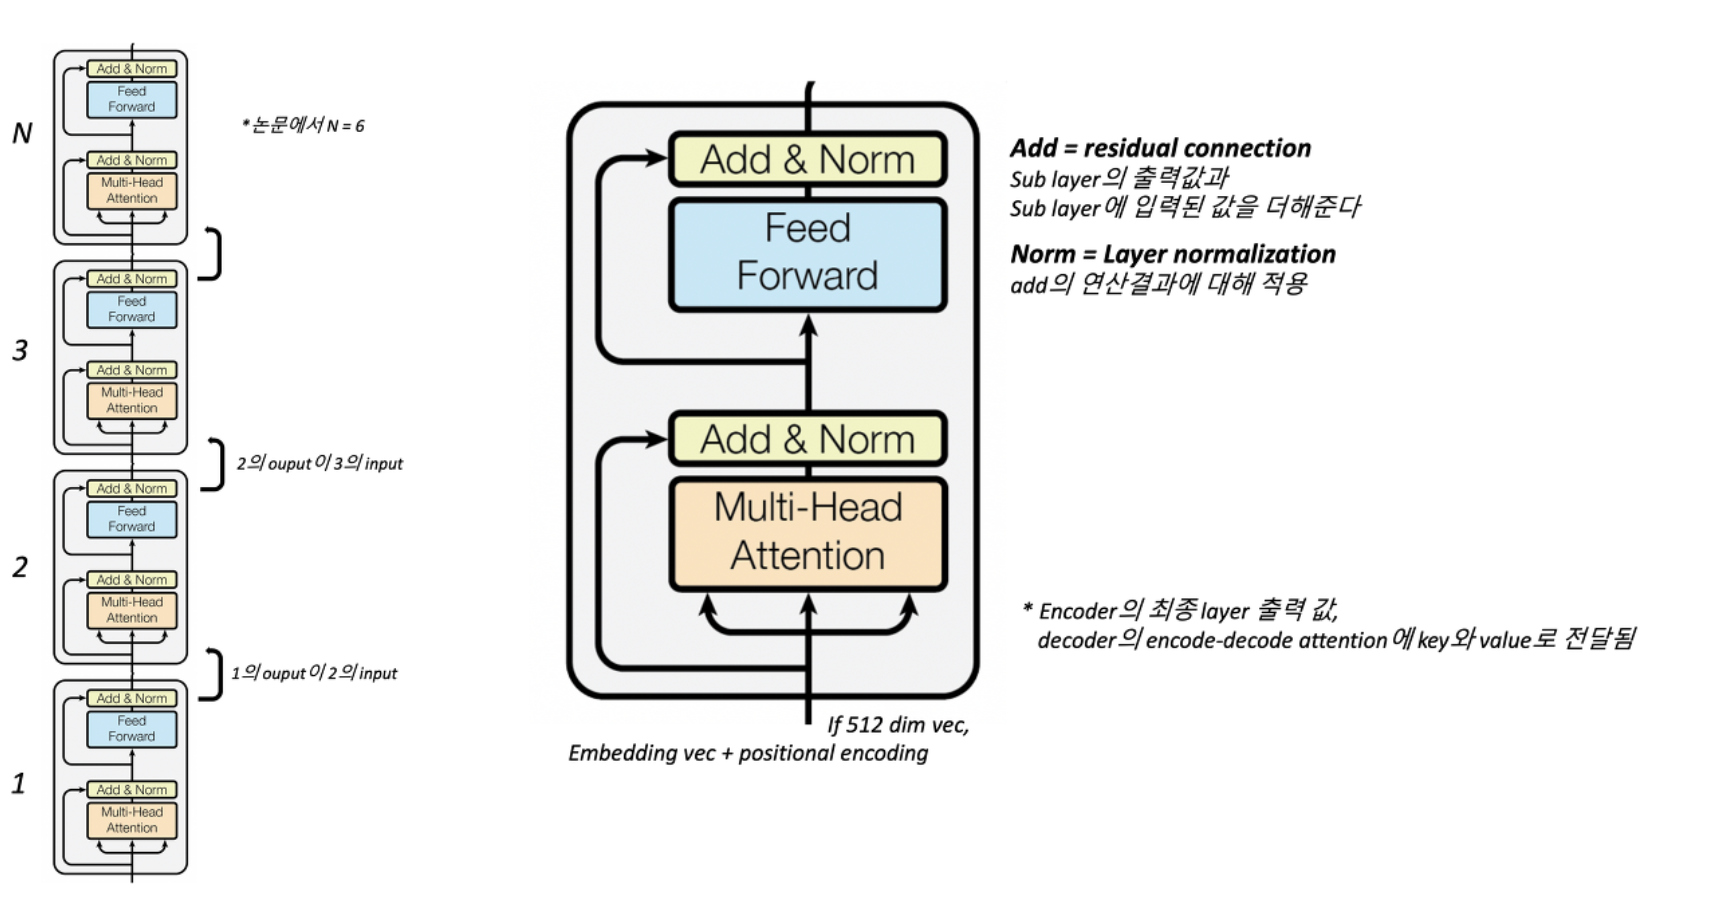

In [ ]:
# 따로 정의한 feed_forward layer

class FeedForward(nn.Module):
  def __init__(self, embed_size, forward_expansion, dropout):
    super(FeedForward,self).__init__()

    self.fc_1 = nn.Linear(embed_size, forward_expansion * embed_size)
    self.fc_2 = nn.Linear(forward_expansion * embed_size, embed_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self, x): # x: [batch, seq_len, embed_size]
    x = self.fc_1(x) # [batch, seq_len, forward_expansion * embed_size]
    x = self.relu(x) 
    x = self.dropout(x)
    x = self.fc_2(x) # [batch, seq_len, embed_size ]
    return x 


In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout):
    super(TransformerBlock, self).__init__()

    self.attention = MultiHeadAttention(embed_size, heads)
    self.attn_layer_norm = nn.LayerNorm(embed_size)
    self.ff_layer_norm = nn.LayerNorm(embed_size)
    self.feed_forward = FeedForward(embed_size,forward_expansion,dropout)
    self.dropout = nn.Dropout(dropout)
  
  # 하나의 src 임베딩을 Q,K,V로 복제하여 입력 
  def forward(self, src, src_mask):
    # attention block & attn_layer_norm
    _src = self.attention(query = src, key = src, value = src, mask = src_mask)
    src = self.attn_layer_norm(src + self.dropout(_src)) # src 그대로와 attention 통과한 _src 둘다 layer_norm 통과 
    
    # feed_forward block & ff_layer_norm
    _src =self.feed_forward(src)
    src = self.ff_layer_norm(src + self.dropout(_src))    
    
    return src

In [ ]:
class Encoder(nn.Module):
  def __init__(self,
             src_vocab_size, # input_dim (하나의 단어에 대한 원핫 인코딩의 차원)
             embed_size, # hidden_dim (하나의 단어에 대한 임베딩 차원)
             num_layers, # num_encoder_layer 
             heads, # num_heads 
             forward_expansion, #feedforward dim / embed_size
             dropout,
             device,
             max_length):
    super(Encoder, self).__init__()
    
    self.device = device

    self.embed_size = embed_size

    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size,
                heads, 
                forward_expansion = forward_expansion,
                dropout = dropout
            )
        for _ in range(num_layers)] # encoder layer 수만큼 반복 
    ) 
    self.dropout = nn.Dropout(dropout)

  def forward(self, src , src_mask):
    # src, src_mask: [batch, src_len]
    
    N, src_len = src.shape

    positions = torch.arange(0, src_len).expand(N, src_len).to(self.device)
    # positions: [batch, src_len]

    # out = src embedding + position embedding 
    out = self.dropout(self.word_embedding(src) + self.position_embedding(positions))
    
    # 각 encoder layer마다 수행  
    for layer in self.layers:
      out = layer(out, src_mask) # 각 layer의 out이 다시 다음 Layer의 input(src)으로
    # out: [batch, src_len, embed_size]

    return out # 마지막 encoder layer의 출력 

In [ ]:
# apply position_encoding 

class Encoder(nn.Module):
  def __init__(self,
             src_vocab_size, # input_dim (하나의 단어에 대한 원핫 인코딩의 차원)
             embed_size, # hidden_dim (하나의 단어에 대한 임베딩 차원)
             num_layers, # num_encoder_layer 
             heads, # num_heads 
             forward_expansion, #feedforward dim / embed_size
             dropout,
             device,
             max_length):
    super(Encoder, self).__init__()
    
    self.device = device

    self.embed_size = embed_size

    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.PositionalEncoding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size,
                heads, 
                forward_expansion = forward_expansion,
                dropout = dropout
            )
        for _ in range(num_layers)] # encoder layer 수만큼 반복 
    ) 
    self.dropout = nn.Dropout(dropout)

  def forward(self, src , src_mask): # src: src_sent from Transformer. 
    # src, src_mask: [batch, src_len]

    # out = src embedding + position encoding 
    
    # word_embedding: [batch, src_len, embed_size]
    # position_embedding: [src_len, embed_size]
    # for each batch, same positional encoding will be applied 
    out = self.dropout(self.word_embedding(src) + self.position_embedding(src))
    
    # 각 encoder layer마다 수행  
    for layer in self.layers:
      out = layer(out, src_mask) # 각 layer의 out이 다시 다음 Layer의 input(src)으로
    # out: [batch, src_len, embed_size]

    return out # 마지막 encoder layer의 출력 

# Decoder

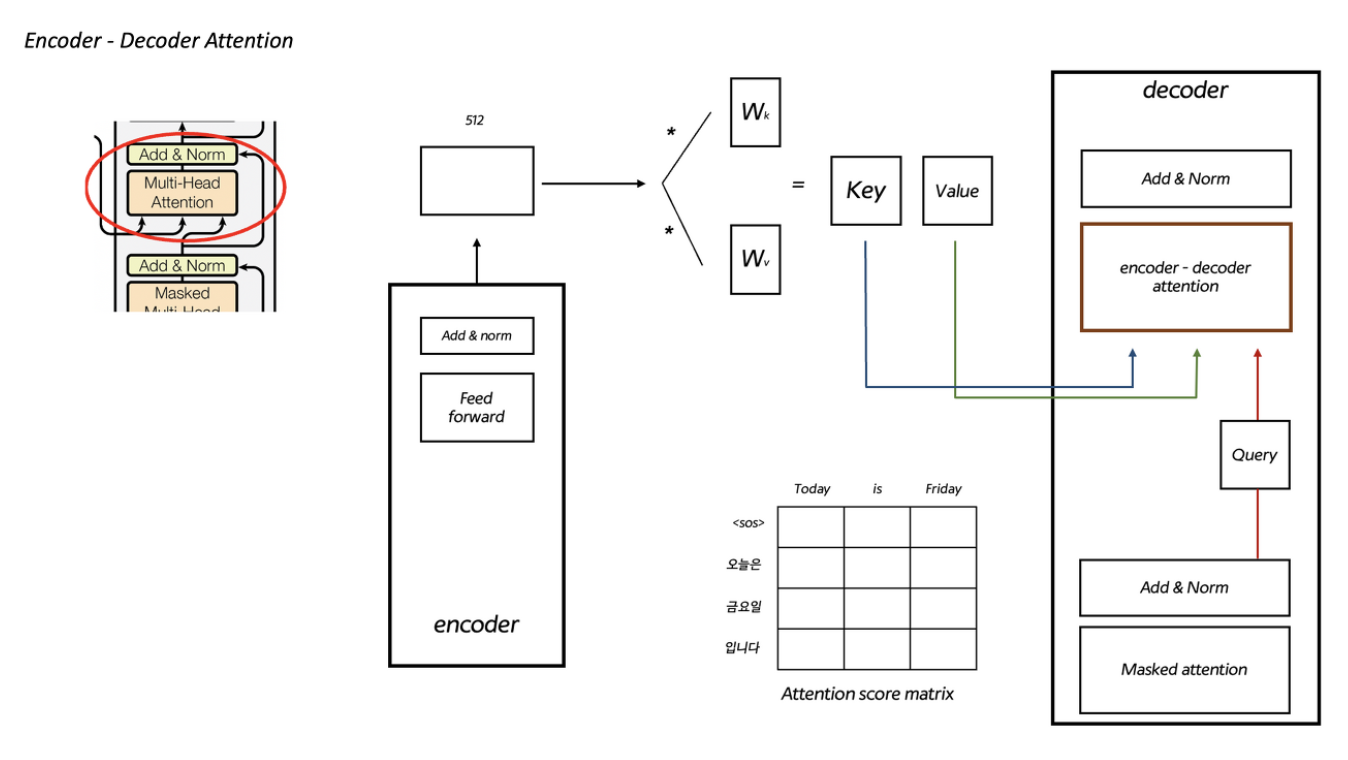

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout, device):
    super(DecoderBlock, self).__init__()

    # 중략해서도 가능함 
    # self.attention = MultiHeadAttention(embed_size, heads)
    # self.norm = nn.LayerNorm(embed_size)
    # self.transformer_block = TransformerBlock(
    #     embed_size, heads, dropout, forward_expansion
    # )
    # self.dropout = nn.Dropout(dropout)

    self.self_attention = MultiHeadAttention(embed_size, heads)
    self.encoder_attention = MultiHeadAttention(embed_size, heads)

    self.ff_layer_norm = nn.LayerNorm(embed_size)
    self.attn_layer_norm = nn.LayerNorm(embed_size)
    self.enc_layer_norm = nn.LayerNorm(embed_size)

    self.feed_forward = FeedForward(embed_size, forward_expansion, dropout)

    self.dropout = nn.Dropout(dropout)

  def forward(self, trg, enc_out, trg_mask, src_mask):
    
    # trg: [batch, trg_len, embed_size]
    # enc_out: [batch, src_len, embed_size]
    # trg_mask : [batch, trg_len]
    # src_mask : [batch, src_len]

    # self attention block
    _trg = self.self_attention(trg,trg,trg,trg_mask)
    
    # LayerNorm (_trg + trg둘다 입력으로) 
    trg = self.attn_layer_norm(trg+self.dropout(_trg))
    # trg : [batch, trg_len, embed_size]

    # encoder attention block
    # Query만 decoder입력인 trg로 받아오고 Key, Value를 encoder의 마지막 layer로 부터 받은 enc_out 
    _trg = self.encoder_attention(trg, enc_out, enc_out, src_mask)

    # LayerNorm()
    trg = self.enc_layer_norm(trg + self.dropout(_trg))
    # trg size same 

    # feed_forward block
    _trg = self.feed_forward(trg)

    # LayerNorm()
    trg = self.ff_layer_norm(trg + self.dropout(_trg))
    # trg size same 

    return trg

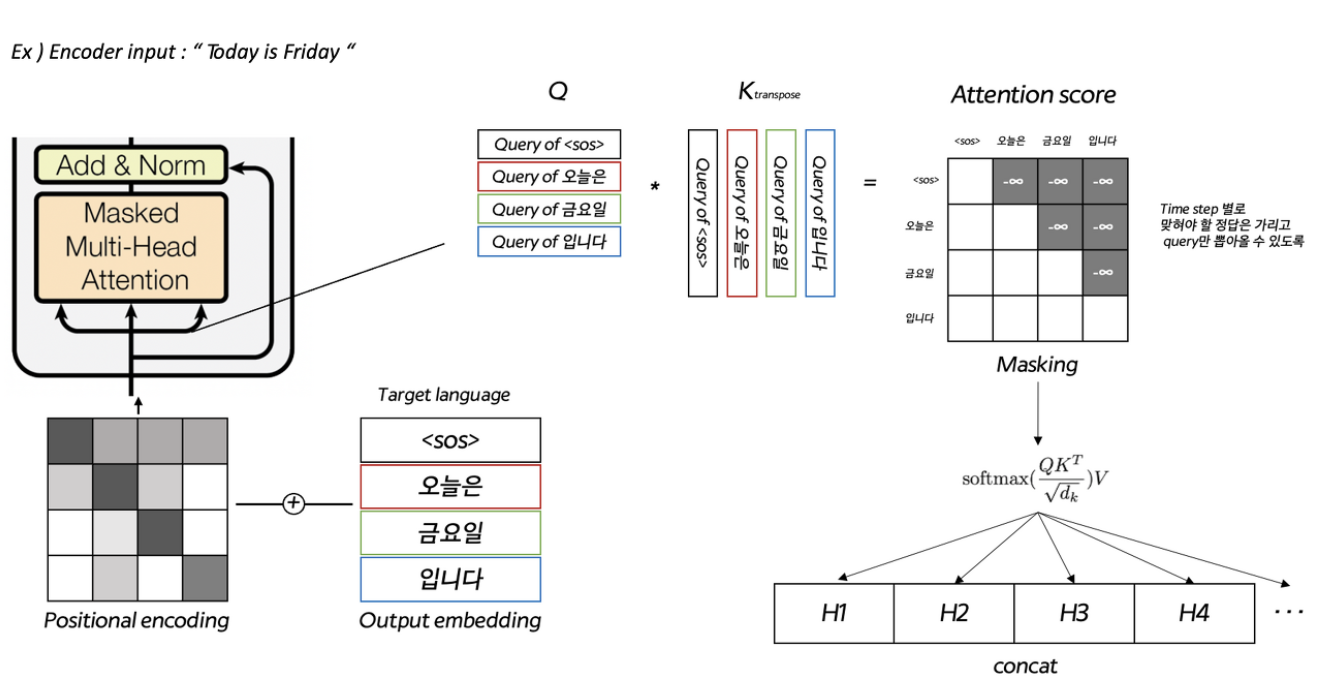

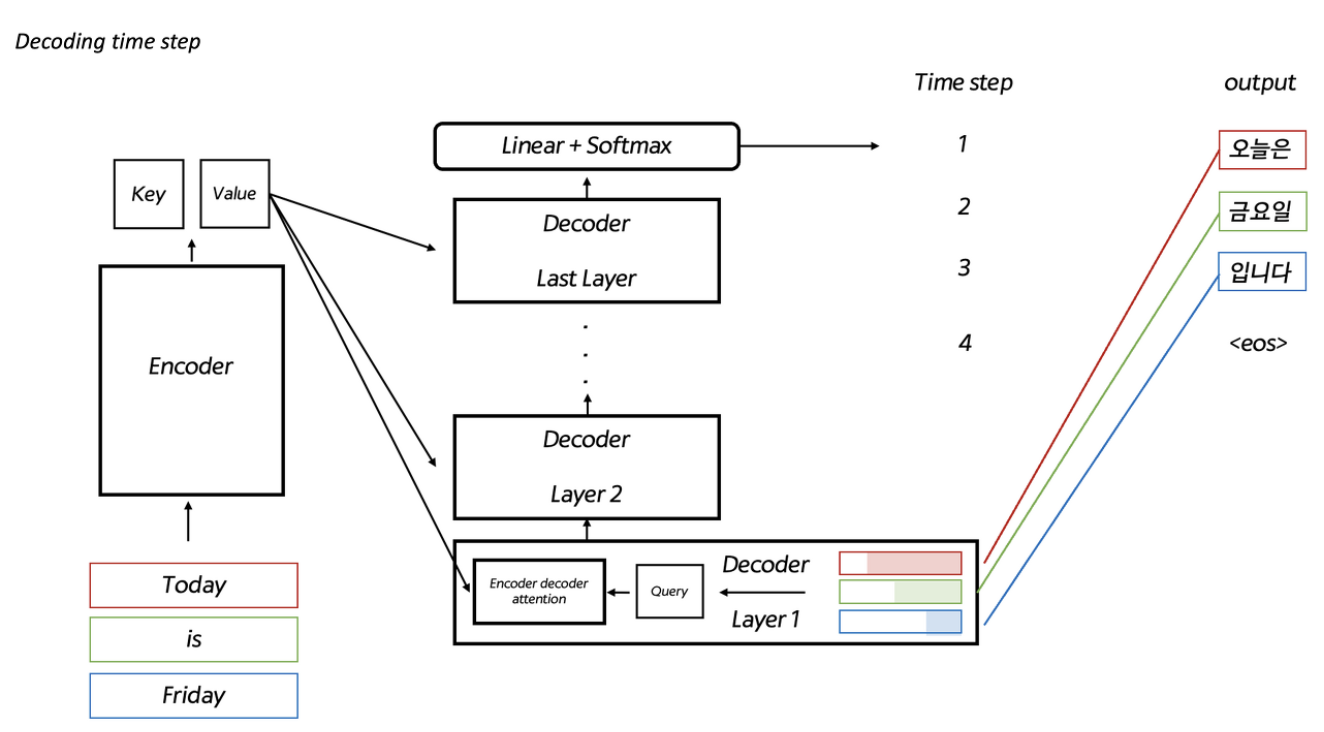

In [ ]:
class Decoder(nn.Module):
  def __init__(self,
               trg_vocab_size,
               embed_size,
               num_layers,
               heads,
               forward_expansion,
               dropout,
               device,
               max_length):
    super(Decoder, self).__init__()

    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)
    
    self.layers = nn.ModuleList(
        [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
        for _ in range(num_layers)]
    )
    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, trg, enc_out, trg_mask, src_mask):
    # trg: [batch, trg_len]
    # enc_out: [batch, src_len, embed_size]
    # trg_mask: [batch, trg_len]
    # src_mask: [batch, src_len]
    N, trg_len = trg.shape
    
    positions = torch.arange(0, trg_len).expand(N, trg_len).to(self.device)
    # positions: [batch, trg_len]

    trg = self.dropout((self.word_embedding(trg))+ self.position_embedding(positions))
    # trg: [batch, trg_len, embed_size]

    for layer in self.layers:
      trg = layer(trg, enc_out, trg_mask, src_mask) # src, trg mask 모두 사용 
    
    out = self.fc_out(trg)
    return out # out : [batch, trg_len, out_dim]


# Transformer

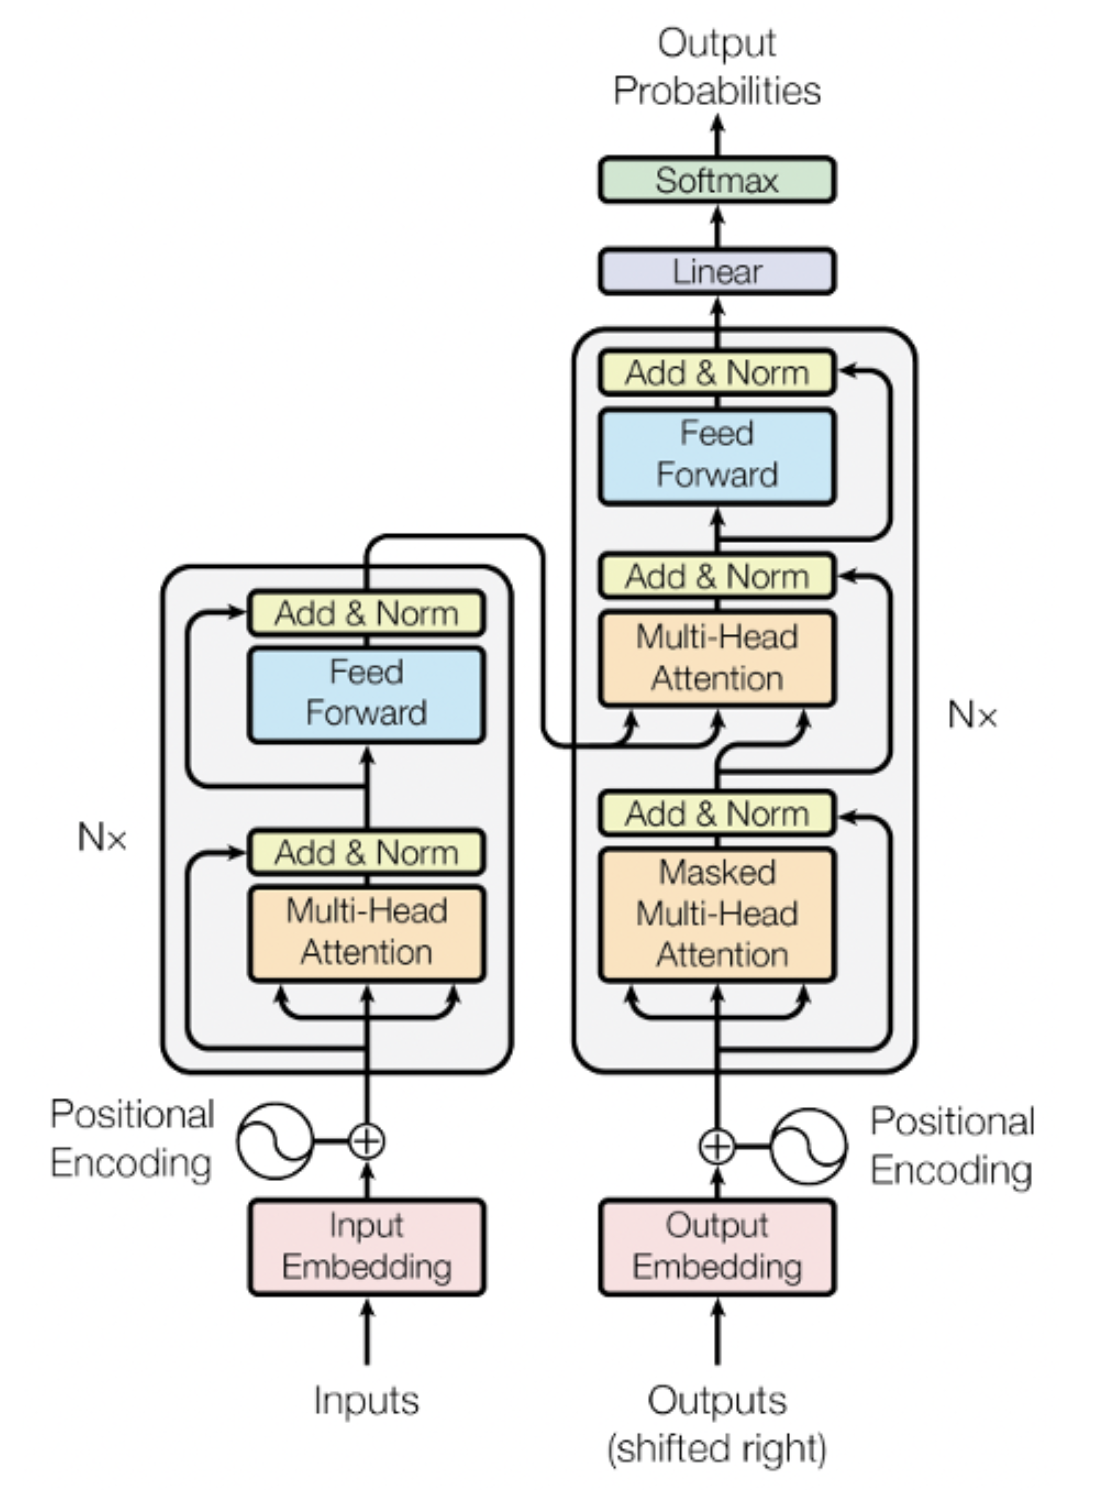

In [ ]:
class Transformer(nn.Module):
  def __init__(self,
               src_vocab_size,
               trg_vocab_size,
               src_pad_idx,
               trg_pad_idx,
               embed_size= 256,
               num_layers =3,
               forward_expansion = 2,
               heads = 8,
               dropout = 0.2,
               max_length = 100,
               device = "cuda"): 
    super(Transformer, self).__init__()


    self.encoder = Encoder(src_vocab_size,
                           embed_size,
                           num_layers,
                           heads,
                           forward_expansion,
                           dropout,
                           device,
                           max_length)

    self.decoder = Decoder(trg_vocab_size,
                           embed_size,
                           num_layers,
                           heads,
                           forward_expansion,
                           dropout,
                           device,
                           max_length)

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  # make_src_mask: 소스문장의 토큰 마스크값을 0으로 
  def make_src_mask(self, src): # src: [batch, src_len]
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # src_mask: [batch,1,1,src_len]
    return src_mask.to(self.device)

  # make_trg_mask: 타겟문장의 각 다음단어를 알 수 없도록 masking (time_step별로)
  def make_trg_mask(self, trg): # trg: [batch, trg_len]
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    ) 
    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_out = self.encoder(src, src_mask) # with src mask 
    out = self.decoder(trg, enc_out, trg_mask, src_mask) # put it into decoder
    return out 

# Pos Encoding

TypeError: ignored

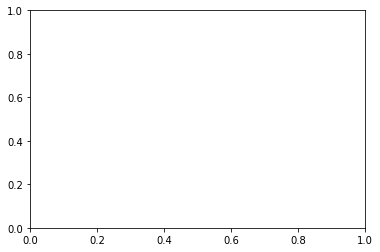

In [ ]:
import math
import matplotlib.pyplot as plt

n = 4 # num_words 
dim = 8 # embed_size

def get_angles(pos, i, dim):
  angles = 1 / math.pow(10000, (2 * (i//2) / dim ))
  return pos * angles

def get_positional_encoding(pos, i, dim):
  if i % 2 ==0:
    return math.sin(get_angles(pos, i, dim)) # sin 함수에 get_angles 집어넣기 

result = [[0] * dim for _ in range(n)]

for i in range(n):
  for j in range(dim):
    result[i][j] = get_positional_encoding(i, j, dim)

plt.pcolormesh(result, cmap='Oranges')

In [ ]:
#https://www.youtube.com/watch?v=LSCsfeEELso 14:31

PE_matrix = torch.zeors(max_seq_len, embed_size).to(device)
pos = torch.arange(0, max_seq_length).unsqueeze(1).float()

for pos in max_seq_len: # each pos is each word of sequence 
  for i in range(embed_size): # each i is index of embed_size 
    if i % 2 ==0: #if its even
      PE_matrix[pos, i] = sin(pos/10000^(i/embed_size))
    if i % 2 ==1: #if its odd
      PE_matrix[pos, i] = cos(pos/10000^(i/embed_size))

In [ ]:
import torch
pe = torch.zeros(10,4) # seq_len = 10, dim =4
print(pe)

pos = torch.arange(0,10).unsqueeze(1).float()
print(pos)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])


In [ ]:
# indicate even/odd indices

two_i = torch.arange(0,4, step=2).float()
print(two_i) # even

div_term = torch.pow(10000, two_i/torch.Tensor([4])).float()
print(div_term)
print(pos)
print(pos / div_term)

tensor([0., 2.])
tensor([  1., 100.])
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])
tensor([[0.0000, 0.0000],
        [1.0000, 0.0100],
        [2.0000, 0.0200],
        [3.0000, 0.0300],
        [4.0000, 0.0400],
        [5.0000, 0.0500],
        [6.0000, 0.0600],
        [7.0000, 0.0700],
        [8.0000, 0.0800],
        [9.0000, 0.0900]])


In [ ]:
pe[:, 0::2] = pos/div_term
pe

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0100, 0.0000],
        [2.0000, 0.0000, 0.0200, 0.0000],
        [3.0000, 0.0000, 0.0300, 0.0000],
        [4.0000, 0.0000, 0.0400, 0.0000],
        [5.0000, 0.0000, 0.0500, 0.0000],
        [6.0000, 0.0000, 0.0600, 0.0000],
        [7.0000, 0.0000, 0.0700, 0.0000],
        [8.0000, 0.0000, 0.0800, 0.0000],
        [9.0000, 0.0000, 0.0900, 0.0000]])

In [ ]:
# sin function 
pe = torch.sin(pe)
pe

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0000,  0.0100,  0.0000],
        [ 0.9093,  0.0000,  0.0200,  0.0000],
        [ 0.1411,  0.0000,  0.0300,  0.0000],
        [-0.7568,  0.0000,  0.0400,  0.0000],
        [-0.9589,  0.0000,  0.0500,  0.0000],
        [-0.2794,  0.0000,  0.0600,  0.0000],
        [ 0.6570,  0.0000,  0.0699,  0.0000],
        [ 0.9894,  0.0000,  0.0799,  0.0000],
        [ 0.4121,  0.0000,  0.0899,  0.0000]])

In [ ]:
# cos for odds 
pe[:, 1::2] = torch.cos(pos/div_term)
pe

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988],
        [-0.2794,  0.9602,  0.0600,  0.9982],
        [ 0.6570,  0.7539,  0.0699,  0.9976],
        [ 0.9894, -0.1455,  0.0799,  0.9968],
        [ 0.4121, -0.9111,  0.0899,  0.9960]])

In [ ]:
pe = pe.unsqueeze(0)
pe, pe.shape[1]# max_len

(tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
          [ 0.8415,  0.5403,  0.0100,  0.9999],
          [ 0.9093, -0.4161,  0.0200,  0.9998],
          [ 0.1411, -0.9900,  0.0300,  0.9996],
          [-0.7568, -0.6536,  0.0400,  0.9992],
          [-0.9589,  0.2837,  0.0500,  0.9988],
          [-0.2794,  0.9602,  0.0600,  0.9982],
          [ 0.6570,  0.7539,  0.0699,  0.9976],
          [ 0.9894, -0.1455,  0.0799,  0.9968],
          [ 0.4121, -0.9111,  0.0899,  0.9960]]]), 10)

In [ ]:
pe[:, :pe.shape[1]].detach()

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992],
         [-0.9589,  0.2837,  0.0500,  0.9988],
         [-0.2794,  0.9602,  0.0600,  0.9982],
         [ 0.6570,  0.7539,  0.0699,  0.9976],
         [ 0.9894, -0.1455,  0.0799,  0.9968],
         [ 0.4121, -0.9111,  0.0899,  0.9960]]])

In [ ]:
import torch.nn as nn


class PositionalEncoding(nn.Module):
  def __init__(self,  max_len, embed_size, dropout=0.1):
    super().__init__()

    self.embed_size = embed_size
    self.dropout = dropout
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    self.pe = torch.zeros(max_len, embed_size).to(self.device)
    self.pe.requires_grad=False #

    pos = torch.arange(0, max_len).unsqueeze(1).float()
    
    two_i = torch.arange(0, embed_size, step=2).float()
    div_term = torch.pow(10000, (two_i/torch.Tensor([embed_size]))).float()
    
    self.pe[:, 0::2] = torch.sin(pos/div_term) # even = sin 
    self.pe[:, 1::2] = torch.cos(pos/div_term) # odd = cos 

    # self.pe = self.pe.unsqueeze(0) # [batch, max_len, embed_size]


  # x input from Embedding 
  def forward(self, x): # x = src: src_sent from Transformer -> embedding 
    batch_size, seq_len = x.shape # 

  
    return self.pe[:seq_len, :]

In [ ]:
x = torch.tensor([[2,3,4,5,6,0,0],[2,6,7,8,0,0,0]])
seq_len = x.shape[1]

src_vocab_size = 50
max_len = 10
embed_size = 4
word_embedding = nn.Embedding(src_vocab_size, embed_size)
print(word_embedding(x))

position_embedding = PositionalEncoding(max_len, embed_size)
print(position_embedding(x))
word_embedding(x) + position_embedding(x)

tensor([[[-1.3978, -0.2763, -0.3401,  0.7064],
         [-1.7620,  0.6295, -0.2299,  0.4465],
         [ 0.2954, -0.2831, -0.0108,  1.3221],
         [ 0.3507,  0.9114, -0.4823,  0.1649],
         [ 1.1310,  0.6084, -1.0777,  1.5461],
         [ 0.3776, -0.1085,  0.2562, -0.0846],
         [ 0.3776, -0.1085,  0.2562, -0.0846]],

        [[-1.3978, -0.2763, -0.3401,  0.7064],
         [ 1.1310,  0.6084, -1.0777,  1.5461],
         [ 1.2149,  1.0359,  1.0012,  0.1647],
         [ 1.2579,  2.1205, -0.5952,  0.3423],
         [ 0.3776, -0.1085,  0.2562, -0.0846],
         [ 0.3776, -0.1085,  0.2562, -0.0846],
         [ 0.3776, -0.1085,  0.2562, -0.0846]]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988],
        [-0.2794,  0.9602,  0.06

tensor([[[-1.3978,  0.7237, -0.3401,  1.7064],
         [-0.9205,  1.1698, -0.2199,  1.4465],
         [ 1.2047, -0.6992,  0.0092,  2.3219],
         [ 0.4918, -0.0786, -0.4523,  1.1645],
         [ 0.3742, -0.0453, -1.0377,  2.5453],
         [-0.5813,  0.1751,  0.3061,  0.9141],
         [ 0.0982,  0.8516,  0.3161,  0.9136]],

        [[-1.3978,  0.7237, -0.3401,  1.7064],
         [ 1.9724,  1.1487, -1.0677,  2.5461],
         [ 2.1242,  0.6197,  1.0212,  1.1645],
         [ 1.3990,  1.1305, -0.5652,  1.3418],
         [-0.3792, -0.7622,  0.2961,  0.9146],
         [-0.5813,  0.1751,  0.3061,  0.9141],
         [ 0.0982,  0.8516,  0.3161,  0.9136]]], grad_fn=<AddBackward0>)

In [ ]:
max_len = 10
embed_size = 4

pe = torch.zeros(max_len, embed_size)
pos = torch.arange(0, max_len).unsqueeze(1).float()
two_i = torch.arange(0, embed_size, step=2).float()
div_term = torch.pow(10000, (two_i/torch.Tensor([embed_size]))).float()
pe[:, 0::2] = torch.sin(pos/div_term)
pe[:, 1::2] = torch.cos(pos/div_term)
pe


pe[:seq_len, :]

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988],
        [-0.2794,  0.9602,  0.0600,  0.9982]])

# see if it works

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(10,10,0,0).to(device)

src = torch.tensor([[1,3,3,2,0,0],[1,4,5,6,2,0]]).to(device)
print(src)

print(model.make_src_mask(src))

src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
src_mask

In [ ]:
trg = torch.tensor([[1,4,3,2,0],[1,3,5,2,0]]).to(device)
print(trg)
print(model.make_trg_mask(trg))

In [ ]:
src_mask = model.make_src_mask(src) 
trg_mask = model.make_trg_mask(trg)

print(src_mask)
print(trg_mask)
enc_out = model.encoder(src, src_mask)
print(enc_out.shape)

out = model.decoder(trg, enc_out, trg_mask, src_mask)
# out = model.encoder(src, src_mask)

# print(out.shape)

In [ ]:
# see if it works

if __name__ == "__main__":  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  x = torch.tensor([[1,5,6,4,3,9,5,2,0], [1,8,7,3,4,5,6,7,2]]).to(device) # src

  trg = torch.tensor([[1,7,4,3,5,9,2,0], [1,5,6,2,4,7,6,2]]).to(device) # trg

  src_pad_idx = 0
  trg_pad_idx = 0
  src_vocab_size = 10
  trg_vocab_size = 10

  #model 
  model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx,).to(device)

  out = model(x, trg) # (src, trg)

In [ ]:
out, out.shape

# (my own)KO - EN translation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
corpus = pd.read_csv('https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/corpus.csv')
train = pd.read_csv('https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/train.csv')
valid = pd.read_csv('https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/valid.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/test.csv')




# train 30000개만 
# train = train[:60000]

corpus.to_csv('/content/drive/MyDrive/translation_data/trans_corpus.csv', index=False)
train.to_csv('/content/drive/MyDrive/translation_data/trans_train.csv', index=False)
valid.to_csv('/content/drive/MyDrive/translation_data/trans_valid.csv', index=False)
test.to_csv('/content/drive/MyDrive/translation_data/trans_test.csv', index=False)
# len(train_df), len(test_df)

print(len(corpus),len(train), len(valid), len(test))

115000 92000 11500 11500


In [ ]:
# csv to dataset 생성함수 
from torchtext.data import TabularDataset
from tqdm.auto import tqdm

def convert_to_dataset(data_path, src_field, trg_field):
  dataset = TabularDataset(path = data_path, format = 'csv',
                           fields = [('src', src_field), ('trg', trg_field)])
  return dataset

In [ ]:
# 최종본
from torchtext.data import Field
import os
import pickle
import argparse

import pandas as pd
from pathlib import Path

from torchtext import data 
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

import spacy
import en_core_web_sm


class BuildVocaToken():
  def __init__(self, corpus_path, train_path, src_vocab_size, trg_vocab_size):
    self.corpus_path = corpus_path
    self.train_path = train_path
    self.spacy_en = spacy.load('en_core_web_sm')
    self.src_vocab_size = src_vocab_size
    self.trg_vocab_size = trg_vocab_size
    
    # empty Field 객체 생성 
    self.SRC = Field(init_token='<SOS>', eos_token='<EOS>',lower=True, batch_first=True)
    self.TRG = Field(init_token='<SOS>', eos_token='<EOS>', lower=True, batch_first=True)

  # 영어(English) 문장을 토큰화 하는 함수
  def tokenize_en(self,text):
    spacy_en = self.spacy_en
    return [token.text for token in spacy_en.tokenizer(text)]

  # 한국어 토크나이저 빌드 using soynlp
  def build_tokenizer(self):
    print("Building soynlp tokenizer from corpus data..")

    corpus_path = self.corpus_path
    df = pd.read_csv(corpus_path, encoding='utf-8')

    # skip the non-text rows
    kor_lines = [row.korean for _, row in df.iterrows() if type(row.korean) == str]

    word_extractor = WordExtractor(min_frequency = 5) # 5번이상 출현단어 
    word_extractor.train(kor_lines)

    word_scores = word_extractor.extract()
    cohesion_scores = {word: score.cohesion_forward
                      for word, score in word_scores.items()}

    return LTokenizer(scores = cohesion_scores)

  def build_vocab(self):
    tokenizer = self.build_tokenizer()
    train_data = convert_to_dataset(self.train_path, self.SRC, self.TRG)
    
    self.SRC.tokenize = tokenizer.tokenize
    self.TRG.tokenize = self.tokenize_en

    print('Build vocab from train_data..')

    self.SRC.build_vocab(train_data, max_size=self.src_vocab_size, min_freq=2)
    self.TRG.build_vocab(train_data, max_size=self.trg_vocab_size, min_freq=2)

    print(f'Unique tokens in Source vocab: {len(self.SRC.vocab)}')
    print(f'Unique tokens in Target vocab: {len(self.TRG.vocab)}')

    # with open('src.pickle', 'wb') as src_file:
    #   pickle.dump(self.SRC, src_file)
    
    # with open('trg.pickle', 'wb') as trg_file:
    #   pickle.dump(self.TRG, trg_file)

    return self.SRC, self.TRG

In [ ]:
train_path = '/content/drive/MyDrive/translation_data/trans_train.csv'
corpus_path = '/content/drive/MyDrive/translation_data/trans_corpus.csv'

s = BuildVocaToken(corpus_path, train_path,29000,20525)
src_tokenizer = s.build_tokenizer() # 한국어 tokenizer 저장 
SRC, TRG = s.build_vocab()

Building soynlp tokenizer from corpus data..
training was done. used memory 3.090 Gb
all cohesion probabilities was computed. # words = 46586
all branching entropies was computed # words = 112737
all accessor variety was computed # words = 112737
Building soynlp tokenizer from corpus data..
training was done. used memory 3.102 Gb
all cohesion probabilities was computed. # words = 46586
all branching entropies was computed # words = 112737
all accessor variety was computed # words = 112737
Build vocab from train_data..
Unique tokens in Source vocab: 29004
Unique tokens in Target vocab: 19736


In [ ]:
len(SRC.vocab), len(TRG.vocab)

(29004, 19736)

## use mecab 

In [ ]:
# use Mecab for KOR 
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
# 한국어 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_ko(text):
    return mecab_ko.morphs(text)

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
import spacy
import en_core_web_sm
# from konlpy.tag import Mecab

spacy_en = spacy.load('en_core_web_sm')

tokenized = spacy_en.tokenizer('pytorch is very easy.')
for i, token in enumerate(tokenized):
  print(i, token)

# # mecab tokenizer 
# mecab_ko = Mecab()

# tokenized = mecab_ko.morphs('파이토치는 매우 쉽습니다.')
# for i, token in enumerate(tokenized):
#   print(i, token)

In [ ]:
text = 'pytorch is very easy.'

# tokenized = spacy_en.tokenizer(text)
# for token in tokenized:
#   print(token.text)

s = spacy_en.tokenizer
s.tokenize

In [ ]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize = tokenize_ko, init_token="<SOS>", eos_token="<EOS>", lower=True, batch_first = True)
TRG = Field(tokenize = tokenize_en, init_token="<SOS>", eos_token="<EOS>", lower=True, batch_first = True)

## use spacy

In [ ]:
import spacy
import en_core_web_sm
import ko_core_news_sm

spacy_en = spacy.load('en_core_web_sm')
spacy_ko = spacy.load("ko_core_news_sm")

tokenized = spacy_ko.tokenizer('파이토치는 배우기 쉽습니다.')
for i, token in enumerate(tokenized):
  print(i, token)

In [ ]:
text = '파이토치는 배우기 쉽습니다.'
[token.text for token in spacy_ko.tokenizer(text)]

In [ ]:
# 한국어 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_ko(text):
    return [token.text for token in spacy_ko.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize = tokenize_ko, init_token="<SOS>", eos_token="<EOS>", lower=True, batch_first = True)
TRG = Field(tokenize = tokenize_en, init_token="<SOS>", eos_token="<EOS>", lower=True, batch_first = True)

## load train data

In [ ]:
train_path = '/content/drive/MyDrive/translation_data/trans_train.csv'
valid_path = '/content/drive/MyDrive/translation_data/trans_valid.csv'
test_path = '/content/drive/MyDrive/translation_data/trans_test.csv'

In [ ]:
train_dataset = convert_to_dataset(train_path, SRC, TRG)
valid_dataset = convert_to_dataset(valid_path, SRC, TRG)
test_dataset = convert_to_dataset(test_path, SRC, TRG)

In [ ]:
# csv to dataset 생성함수 
# from torchtext.data import TabularDataset

# def convert_to_dataset(data_path, src_field, trg_field):
#   dataset = TabularDataset(path = data_path, format = 'csv',
#                            fields = [('src', src_field), ('trg', trg_field)])
#   return dataset

In [ ]:
len(train_dataset)

92001

In [ ]:
# make iter 함수 
from torchtext.data import Field, BucketIterator
from torchtext.data import TabularDataset

#
def convert_to_dataset(data_path, src_field, trg_field):
  dataset = TabularDataset(path = data_path, format = 'csv',
                           fields = [('src', src_field), ('trg', trg_field)])
  return dataset




def make_iterator(batch_size,
                  mode,
                  src_field, trg_field,
                  train_path=None, valid_path=None, test_path=None):
    # Args
    # batch_size: (int)
    # mode: (str) 'train'/'test' 
    # train/valid/test_path: (str) csv_data_dir
  
  # file_src = open('src.pickle', 'rb')
  # src = pickle.load(file_src)
  # file_trg = open('trg.pickle', 'rb')
  # trg = pickle.load(file_trg)


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  
  if mode == 'train': # use convert_to_dataset func
    train_dataset = convert_to_dataset(train_path, src_field, trg_field)
    valid_dataset = convert_to_dataset(valid_path, src_field, trg_field)

    # use BucketIterator to make iterator 
    train_iterator, valid_iterator = BucketIterator.splits(
        datasets = (train_dataset,valid_dataset),
        batch_sizes= (batch_size,batch_size),
        device=device,
        sort=False)
                                                           
    return train_iterator, valid_iterator

  else:
    test_dataset = convert_to_dataset(test_path, src_field, trg_field)
    test_iterator = BucketIterator(test_dataset,
                                    batch_size = batch_size,
                                    device = device,
                                    sort=False)
    return test_iterator





In [ ]:
train_path, valid_path, test_path

('/content/drive/MyDrive/translation_data/trans_train.csv',
 '/content/drive/MyDrive/translation_data/trans_valid.csv',
 '/content/drive/MyDrive/translation_data/trans_test.csv')

In [ ]:
train_iterator, valid_iterator = make_iterator(batch_size=256, mode='train', src_field = SRC,
              trg_field = TRG, train_path = train_path, valid_path = valid_path)
test_iterator = make_iterator(batch_size=256, mode='test', src_field = SRC,
              trg_field = TRG, test_path = test_path)

In [ ]:
len(train_iterator)

360

In [ ]:
# model class 먼저 실행 

In [ ]:
# params 


class ModelParams:
    def __init__(self,
                 embed_size=256,
                 num_layers=3,
                 forward_expansion=2,
                 heads=8,
                 dropout=0.2,
                 max_length=100):
        
        self.embed_size = embed_size 
        self.num_layers = num_layers 
        self.forward_expansion = forward_expansion 
        self.heads = heads 
        self.dropout = dropout 
        self.max_length = max_length
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def load_vocab_params(self,src_field, trg_field):
        
        src_vocab_size = len(src_field.vocab)
        trg_vocab_size = len(trg_field.vocab)
        src_pad_idx = src_field.vocab.stoi[src_field.pad_token]
        trg_pad_idx = trg_field.vocab.stoi[trg_field.pad_token]

        params = {'src_vocab_size': src_vocab_size,
                  'trg_vocab_size': trg_vocab_size,
                  'src_pad_idx': src_pad_idx,
                  'trg_pad_idx': trg_pad_idx,

                  'embed_size': self.embed_size,
                  'num_layers': self.num_layers,
                  'forward_expansion': self.forward_expansion,
                  'heads':self.heads,
                  'dropout': self.dropout,
                  'max_length': self.max_length,
                  'device': self.device}
        
        return params

        

In [ ]:
# in paper base model params 
params = ModelParams(embed_size = 512,
                     num_layers = 6,
                     forward_expansion = 4,
                     heads=8,
                     dropout=0.1,
                     max_length=50)
params = params.load_vocab_params(src_field = SRC, trg_field = TRG)
(params['src_vocab_size'],params['trg_vocab_size'])

(29004, 19736)

In [ ]:
import numpy as np
class ScheduledOptim:
    '''스케줄 옵티마이저'''
    def __init__(self, optimizer, warmup_steps=None):
        self.init_lr = np.power(params['embed_size'], -0.5)
        self.optimizer = optimizer
        self.step_num = 0
        self.warmup_steps = warmup_steps
    
    def step(self):
        self.step_num += 1 # per each step forward 
        lr = self.init_lr * self.get_scale() # scailing lr 
        
        for p in self.optimizer.param_groups: # Add a param group to the Optimizer s param_groups
            p['lr'] = lr
            
        self.optimizer.step()
    
    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def get_scale(self): # scaling lr 
        return np.min([
            np.power(self.step_num, -0.5), # step_num ** -0.5  
            self.step_num * np.power(self.warmup_steps, -1.5)
        ])

In [ ]:
# trainer class 

import torch
import random

random.seed(0)
torch.manual_seed(0)


class TransTrainer:
    def __init__(self, mode, params, train_iter=None, valid_iter=None, test_iter=None):
        # mode: (str) 'train' / 'test'
        self.params = params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = Transformer(self.params['src_vocab_size'],
                                 self.params['trg_vocab_size'],
                                 self.params['src_pad_idx'],
                                 self.params['trg_pad_idx'],
                                 self.params['embed_size'],
                                 self.params['num_layers'],
                                 self.params['forward_expansion'],
                                 self.params['heads'],
                                 self.params['dropout'],
                                 self.params['max_length'],
                                 self.params['device']).to(self.device)
        print(self.model)

        self.criterion = torch.nn.CrossEntropyLoss(ignore_index = self.params['trg_pad_idx'])
        

        if mode == 'train':
            self.train_iter = train_iter
            self.valid_iter = valid_iter
        else: # 'test'
            self.test_iter = test_iter
        
        print('initializing weights..')
        self.model.apply(self.initialize_weights)
        # print(self.model)
        print(f'The model has {self.count_parameters(self.model):,} trainable parameters')

    # num_param count
    def count_parameters(self,model):  
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
    # weight initialization
    def initialize_weights(self,m):
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)



    def train(self, epochs = 10, optimizer = 'Adam', clip=1):
        
        if optimizer == 'Adam':
            optimizer = ScheduledOptim(torch.optim.Adam(self.model.parameters(),
                                                        betas = [0.9, 0.98],
                                                        eps = 1e-9),
                                                        warmup_steps=4000
                                                        )
        
        elif optimizer == 'SGD':
            optimizer = ScheduledOptim(torch.optim.SGD(self.model.parameters(),lr=5e-4)
                                                        )
                                                        

        best_valid_loss = float('inf')

        print('start training..')
        for epoch in tqdm(range(epochs)):
            self.model.train() # train_mode 
            epoch_loss = 0

            for batch in tqdm(self.train_iter): 
                src = batch.src
                trg = batch.trg

                optimizer.zero_grad()
                output = self.model(src, trg[:, :-1]) # trg except <EOS> token
                
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                trg = trg[:, 1:].contiguous().view(-1)
                # output = [(batch * trg_length -1) , output_dim]
                # trg = [(batch * trg_length -1)]

                loss = self.criterion(output, trg)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)
                
                optimizer.step()
                epoch_loss += loss.item()
        
            train_loss = epoch_loss / len(self.train_iter)
            valid_loss = self.evaluate()

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(self.model.state_dict(), "transformer_ko_to_en.pt")

            print(f'Epoch: {epoch + 1:02}')
            print(f'\tTrain Loss: {train_loss: .3f}')
            print(f'\tValid Loss: {valid_loss: .3f}')
    
    def evaluate(self):
        self.model.eval()
        epoch_loss = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_iter):
                src = batch.src
                trg = batch.trg
 
                output = self.model(src, trg[:, :-1])
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                trg = trg[:, 1:].contiguous().view(-1)
                loss = self.criterion(output, trg)

                epoch_loss += loss.item()

        return epoch_loss / len(self.valid_iter)


    def test(self):
        self.model.load_state_dict(torch.load('transformer_ko_to_en.pt'))
        self.model.eval()
        epoch_loss=0

        with torch.no_grad():
            for batch in self.test_iter:
                src = batch.src
                trg = batch.trg
 
                output = self.model(src, trg[:, :-1])
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                trg = trg[:, 1:].contiguous().view(-1)
                loss = self.criterion(output, trg)

                epoch_loss += loss.item()

        test_loss = epoch_loss / len(self.test_iter)
        print(f'Test Loss: {test_loss:.3f}')


In [ ]:
params

{'src_vocab_size': 29004,
 'trg_vocab_size': 19736,
 'src_pad_idx': 1,
 'trg_pad_idx': 1,
 'embed_size': 512,
 'num_layers': 6,
 'forward_expansion': 4,
 'heads': 8,
 'dropout': 0.1,
 'max_length': 50,
 'device': device(type='cuda')}

In [ ]:
trainer = TransTrainer('train', params, train_iterator, valid_iterator, test_iterator)
trainer.train()

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(29004, 512)
    (position_embedding): Embedding(50, 512)
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (fc_queries): Linear(in_features=512, out_features=512, bias=True)
          (fc_keys): Linear(in_features=512, out_features=512, bias=True)
          (fc_values): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc_1): Linear(in_features=512, out_features=2048, bias=True)
          (fc_2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
  

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 01
	Train Loss:  7.471
	Valid Loss:  5.376


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 02
	Train Loss:  5.050
	Valid Loss:  4.576


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 03
	Train Loss:  4.395
	Valid Loss:  4.101


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 04
	Train Loss:  4.017
	Valid Loss:  3.807


  0%|          | 0/360 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
trainer = TransTrainer('test', params, test_iter = test_iterator)
trainer.test()

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(29004, 512)
    (position_embedding): Embedding(50, 512)
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (fc_queries): Linear(in_features=512, out_features=512, bias=True)
          (fc_keys): Linear(in_features=512, out_features=512, bias=True)
          (fc_values): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc_1): Linear(in_features=512, out_features=2048, bias=True)
          (fc_2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
from tqdm import tqdm

# training loop
def train(model, iterator, optimizer, criterion, clip):
  model.train() # train mode
  epoch_loss = 0

  # for i, batch in enumerate(iterator):
  for batch in iterator:
    src = batch.src
    trg = batch.trg

    optimizer.zero_grad()

    output = model(src, trg[:, :-1]) # trg except <EOS> token 
    
    output_dim = output.shape[-1]
    output = output.contiguous().view(-1, output_dim)
    trg = trg[:, 1:].contiguous().view(-1)
    
    loss = criterion(output, trg)
    
    # gradient clipping 
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
  
  return epoch_loss/ len(iterator)


In [ ]:
# evaluation 
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    # for i, batch in enumerate(iterator):
    for batch in iterator:
      src = batch.src
      trg = batch.trg

      output = model(src, trg[:, :-1])
      output_dim = output.shape[-1]
      output = output.contiguous().view(-1, output_dim)
      trg = trg[:, 1:].contiguous().view(-1)
      loss = criterion(output, trg)

      epoch_loss += loss.item()
  return epoch_loss/len(iterator) 

In [ ]:
import time
import math
import random
import tqdm
from tqdm.auto import tqdm

num_epochs = 20
clip = 1
best_valid_loss = float('inf')

for epoch in tqdm(range(num_epochs)): 

  train_loss = train(model, train_iterator, optimizer, criterion, clip)
  valid_loss = evaluate(model, valid_iterator, criterion)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    
    torch.save(model.state_dict(), "transformer_ko_to_en.pt")
    

  print(f'Epoch: {epoch + 1:02}')
  print(f'\tTrain Loss: {train_loss: .3f}')
  print(f'\tValid Loss: {valid_loss: .3f}')

  # best : 1e-3 / dropout 0.2 / embed_size 256 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01
	Train Loss:  5.247
	Valid Loss:  4.349


KeyboardInterrupt: ignored

In [ ]:
# test
model.load_state_dict(torch.load('transformer_ko_to_en.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print("Test Loss: {:.3f}".format(test_loss))

Test Loss: 2.390


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(params['src_vocab_size'],
                      params['trg_vocab_size'],
                      params['src_pad_idx'],
                      params['trg_pad_idx'],
                      params['embed_size'],
                      params['num_layers'],
                      params['forward_expansion'],
                      params['heads'],
                      params['dropout'],
                      params['max_length'],
                      params['device']).to(device)


a = vars(test_dataset[10])['src']
tokens = [token for token in a]
tokens,a

tokens = [SRC.init_token] + tokens + [SRC.eos_token]
print(f'전체 소스토큰 : {tokens}')
src_indexes = [SRC.vocab.stoi[token] for token in tokens]
print(f'소스 문장 인덱스: {src_indexes}')
src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
print(src_tensor)
src_mask = model.make_src_mask(src_tensor)
print(src_mask)


with torch.no_grad():
  enc_out = model.encoder(src_tensor, src_mask)

print("enc_out", enc_out)

trg_indexes = [TRG.vocab.stoi[TRG.init_token]]
print('trg_indexes', trg_indexes)


for i in range(50):
  trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
  print("trg_tensor:", trg_tensor)
  trg_mask = model.make_trg_mask(trg_tensor)
  print("trg_mask:", trg_mask)
  
  with torch.no_grad():
    # encoder out 과 함께 decoder에서 attention 
    output = model.decoder(trg_tensor, enc_out, trg_mask, src_mask)
    print("decoder_output:",output)
    
    # 출력문장의 가장 마지막 단어 
    pred_token = output.argmax(2)[:, -1].item()
    print("output.argmax:",output.argmax(2))
    print("pred_token:", pred_token)
    trg_indexes.append(pred_token) # 예측한 토큰을 index에 넣어주고 
    print("trg_indexes:", trg_indexes)
    # <EOS> token 만나면 종료  
    if pred_token == TRG.vocab.stoi[TRG.eos_token]: #해당과정을 <eos> token만날때까지 
      break # 만나면 break 

전체 소스토큰 : ['<SOS>', '혹시', '호텔', '로', '가시나요?', '택시', '가', '필요', '하신가요?', '<EOS>']
소스 문장 인덱스: [2, 27, 280, 0, 4806, 435, 498, 1637, 0, 3]
tensor([[   2,   27,  280,    0, 4806,  435,  498, 1637,    0,    3]],
       device='cuda:0')
tensor([[[[True, True, True, True, True, True, True, True, True, True]]]],
       device='cuda:0')
enc_out tensor([[[-0.0869, -1.2632, -0.0022,  ..., -0.8796,  0.3938,  0.3656],
         [ 0.9727, -0.8528, -0.6608,  ..., -1.0656, -1.2077, -0.4928],
         [-1.3641,  0.7087, -0.6527,  ...,  1.2969,  0.3930, -0.2057],
         ...,
         [ 0.8628,  0.2108,  0.5462,  ..., -1.4999,  1.0097, -0.1498],
         [ 0.5683,  0.1624, -0.1077,  ...,  0.4059, -0.0634,  0.4208],
         [-0.0398, -0.3573, -1.2358,  ...,  0.4418,  0.5664, -1.2498]]],
       device='cuda:0')
trg_indexes [2]
trg_tensor: tensor([[2]], device='cuda:0')
trg_mask: tensor([[[[1.]]]], device='cuda:0')
decoder_output: tensor([[[ 0.0869, -0.2842,  0.3843,  ..., -0.0801,  0.3679, -0.5008]]],
  

In [ ]:
tknzed = src_tokenizer.tokenize('혹시 호텔로 가시나요? 택시가 필요하신가요?')
tknzed

['혹시', '호텔', '로', '가시나요?', '택시', '가', '필요', '하신가요?']

In [ ]:
# spacy_en = spacy.load('en_core_web_sm')
# spacy_de = spacy.load('de_core_news_sm')

# translate sentence
def translate_sentence(sentence, src_field, trg_field,
                       params,
                       max_len=50,
                       logging=True):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Transformer(params['src_vocab_size'],
                      params['trg_vocab_size'],
                      params['src_pad_idx'],
                      params['trg_pad_idx'],
                      params['embed_size'],
                      params['num_layers'],
                      params['forward_expansion'],
                      params['heads'],
                      params['dropout'],
                      params['max_length'],
                      params['device']).to(device)                
  model.load_state_dict(torch.load('transformer_ko_to_en.pt'))
  model.eval()

  if isinstance(sentence, str): # 문자열을 입력받으면
    tokenizer = src_tokenizer
    tokens = tokenizer.tokenize(sentence)
  else:
    tokens = sentence

  tokens = [src_field.init_token] + tokens + [src_field.eos_token]
  if logging == True:
    print(f'전체 소스토큰 : {tokens}')


  src_indexes = [src_field.vocab.stoi[token] for token in tokens]
  if logging == True:
    print(f'소스 문장 인덱스: {src_indexes}')
  
  # into tensor 
  src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
  
  # mask src mask 
  src_mask = model.make_src_mask(src_tensor)
  

  with torch.no_grad():
    enc_out = model.encoder(src_tensor, src_mask)
    
  
  # 처음엔 시작토큰만 
  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
  

  for i in range(max_len):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
    # make target mask 
    trg_mask = model.make_trg_mask(trg_tensor)
    
    
    # encoder out 과 함께 decoder에서 attention 
    with torch.no_grad():
      output = model.decoder(trg_tensor, enc_out, trg_mask, src_mask)
    
    # last word token of output  
    pred_token = output.argmax(2)[:, -1].item()
    
    # append last token to index 
    trg_indexes.append(pred_token)
    
    # <EOS> token 만나면 종료  
    if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
      break
    
  # index_to_sentence
  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:]


In [ ]:
sentence = vars(test_dataset[50])['src']
params = params 

pred = translate_sentence(sentence,SRC,TRG, params, logging=True)
print("예측:", pred)
print("정답:",vars(test_dataset[50])['trg'])

전체 소스토큰 : ['<SOS>', '논문', '제출', '및', '참석', '에', '대한', '비용을', '지불하', '였어요.', '<EOS>']
소스 문장 인덱스: [2, 5157, 2925, 714, 2822, 12026, 98, 758, 0, 17743, 3]
예측: ['supplying', 'present?', 'domestic', 'swap', 'salad,', 'jim,', 'overlap', 'things.', 'senses.', 'restriction.', 'regrets', 'exist', 'graded', 'overlapped.', 'twice', 'week.', 'nutritious', 'us.', 'unbelievably', 'approval.', 'function,', 'domestic', 'airport#.', 'extra?', 'photoshop.', 'seoul', 'lined', 'passes.', 'today!', 'shellfish.', 'ocean,', 'restriction.', 'common', 'serious', 'distinctive', '#hilton', 'picks', 'countryside', 'installed.', 'monkey', 'strikes', 'misunderstood.', 'flour', 'afterward', 'serious', '#haeundae#', "car's", 'reset', 'extraordinary', 'café']
정답: ['i', 'submitted', 'the', 'thesis', 'and', 'paid', 'the', 'expense', 'for', 'participation', '.']


In [ ]:
test_dataset = convert_to_dataset(test_path, SRC, TRG)

In [ ]:
example_idx = 10

src = vars(test_dataset[example_idx])['src']
trg = vars(test_dataset[example_idx])['trg']

print("src_sentence:", src)
print("trg_sentence:", trg)

translation = translate_sentence(sentence = src,
                                  src_field = SRC,
                                  trg_field = TRG,
                                  model = model,
                                  device = device,
                                  logging=True)

print("output:", " ".join(translation))



src_sentence: ['혹시', '호텔', '로', '가시나요?', '택시', '가', '필요', '하신가요?']
trg_sentence: ['do', 'you', 'go', 'to', 'a', 'hotel', '?', 'do', 'you', 'need', 'a', 'taxi', '?']
전체 소스토큰 : ['<SOS>', '혹시', '호텔', '로', '가시나요?', '택시', '가', '필요', '하신가요?', '<EOS>']
소스 문장 인덱스: [2, 27, 280, 0, 4806, 435, 498, 1637, 0, 3]
output: do you need a taxi fare if you go to the hotel ? <EOS>


In [ ]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}')

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')  

In [ ]:
# 1000개의 데이터만 bleu스코어 측정 
import torch.utils.data as data
index = torch.arange(1000)
bleu_test_dataset = data.Subset(test_dataset, index)

In [ ]:
len(bleu_test_dataset)

1000

In [ ]:
show_bleu(bleu_test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['the', 'cell', 'phone', 'has', 'a', 'hit', 'and', 'the', 'internet', '.']
정답: ['there', 'is', 'a', 'clock', 'between', 'a', 'cell', 'phone', 'and', 'a', 'scissor', '.']
[200/1000]
예측: ['i', 'do', '<unk>', 'want', 'to', 'meet', 'each', 'other', 'anymore', '.']
정답: ['i', 'do', "n't", 'want', 'to', 'meet', 'you', 'personally', 'anymore', '.']
[300/1000]
예측: ['i', 'think', 'it', 'might', 'be', 'meaningful', 'and', '<unk>', '.']
정답: ['it', 'would', 'be', 'difficult', 'to', 'understand', 'what', 'it', 'means', '.']
[400/1000]
예측: ['practice', 'for', 'a', 'putt', 'before', 'you', 'start', '.']
정답: ['take', 'a', 'few', 'practice', 'swings', 'before', 'hitting', 'a', 'ball', '.']
[500/1000]
예측: ['i', 'need', 'to', 'check', 'the', 'volume', '.']
정답: ['i', 'have', 'to', 'make', 'a', 'call', 'on', 'a', 'landline', '.']
[600/1000]
예측: ['it', 'looks', 'like', 'our', 'team', 'leader', 'asked', 'us', 'to', 'come', '.']
정답: ['it', 'looks', 'like', 'a', 'new', 'bookkeeper', 'will', 'join

# En -KO 

In [ ]:
! pip install transformers

In [ ]:
import pandas as pd
ko_en_train = pd.read_csv('https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/train.csv')


In [ ]:
ko_en_train

In [ ]:
import numpy as np

# utis 

def make_std_mask(tgt, pad_token_idx):
  'Create a mask to hide padding and future words.'
  target_mask = (tgt != pad_token_idx).unsqueeze(-2)
  target_mask = target_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(target_mask.data))
  return target_mask.squeeze()

def subsequent_mask(size):
  "Mask out subsequent positions."
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

def load_csv(dataframe):
  lines = []
  for i in range(len(dataframe)):
    line = [dataframe.values[i][0] , dataframe.values[i][1]]
    lines.append(line)
  return lines

In [ ]:
spacy_ko.tokenizer.pad_token_idx, spacy_en.tokenizer

In [ ]:
import csv
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer
from torch.autograd import Variable
from tqdm.auto import tqdm

class TranslationDataset(Dataset):
  def __init__(self, tokenizer, dataframe, max_length:int):
    pad_token_idx = tokenizer.pad_token_id # pad_token_idx=0
    csv_datas = load_csv(dataframe)
    self.docs = []
    # for line in csv_datas: # line[0] 한글, line[1] 영어
    for line in tqdm(csv_datas):
      input = tokenizer.encode(line[0],max_length=max_length,truncation=True)
      rest = max_length - len(input)
      input = torch.tensor(input + [pad_token_idx]*rest)

      target = tokenizer.encode(line[1], max_length=max_length, truncation=True)
      rest = max_length - len(target)
      target = torch.tensor(target+ [pad_token_idx] * rest)

      doc={
        #'og_input':line[0], # original input 저장 
        #'og_target':line[1],# orignal target 
        'input_str': tokenizer.convert_ids_to_tokens(input),
        'input':input,                                        # input
        #'input_mask': (input != pad_token_idx).unsqueeze(-2),       # input_mask
        'target_str': tokenizer.convert_ids_to_tokens(target),
        'target': target,                                       # target,
        #'target_mask': make_std_mask(target, pad_token_idx),    # target_mask
        #'token_num': (target[...,1:] != pad_token_idx).data.sum()  # token_num
      }
      self.docs.append(doc)

  # def make_std_mask(self,tgt, pad_token_idx):
  #   'Create a mask to hide padding and future words.'
  #   target_mask = (tgt != pad_token_idx).unsqueeze(-2)
  #   target_mask = target_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(target_mask.data))
  #   return target_mask.squeeze()

  # def subsequent_mask(self,size):
  #   attn_shape = (1, size, size)
  #   subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  #   return torch.from_numpy(subsequent_mask) == 0

  def load_csv(self,dataframe):
    lines = []
    for i in range(len(dataframe)):
      src_trg = [dataframe.values[i][0] , dataframe.values[i][1]] 
      lines.append(src_trg)
    return lines # [ [src_sent, trg_sent], [], [].. ]

  def __len__(self):
    return len(self.docs)
  def __getitem__(self, idx):
    item = self.docs[idx]
    return item

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
print(tokenizer.encode('파이토치는 배우기 쉽습니다.'))
print(tokenizer.encode('pytroch is easy to learn.', max_length=30))
print(tokenizer.vocab_size)

In [ ]:
tokenizer.decode([1180])

In [ ]:
ko_en_train = ko_en_train.loc[:30000]
ko_en_train

In [ ]:
max_length = 100
dataset = TranslationDataset(tokenizer = tokenizer, dataframe=ko_en_train, max_length = max_length)

In [ ]:
dataset

In [ ]:
def collate_fn(samples):
  input_str = []
  target_str = []
  og_input = []
  og_target = []

  og_input.append([sample['og_input'] for sample in samples])
  og_target.append([sample['og_target'] for sample in samples])

  input_str.append([sample['input_str'] for sample in samples])
  input = [sample['input'] for sample in samples]
  input_mask = [sample['input_mask'] for sample in samples]

  target_str.append([sample['target_str'] for sample in samples])
  target = [sample['target'] for sample in samples]
  target_mask = [sample['target_mask'] for sample in samples]
  token_num = [sample['token_num'] for sample in samples]

  return{
      "og_input":og_input,
      "og_target":og_target,
      "input_str":input_str,
      "input":torch.stack(input).contiguous(),
      "input_mask":torch.stack(input_mask).contiguous(),
      "target_str":target_str,
      "target":torch.stack(target).contiguous(),
      "target_mask":torch.stack(target_mask).contiguous(),
      "token_num":torch.stack(token_num).contiguous()
  }

b = collate_fn(dataset)
b['og_input']

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
def build_dataloaders(dataset, train_test_split = 0.1, train_shuffle=True, eval_shuffle=True):
  dataset_len = len(dataset)
  eval_len = int(dataset_len * train_test_split)
  train_len = dataset_len - eval_len
  
  train_dataset, eval_dataset = random_split(dataset, (train_len, eval_len))

  train_loader = DataLoader(train_dataset,
                            batch_size = 32,
                            shuffle = train_shuffle,
                            collate_fn = collate_fn,
                            )
  
  eval_loader = DataLoader(eval_dataset,
                            batch_size = 32,
                            shuffle = eval_shuffle,
                            collate_fn = collate_fn,
                           )
  return train_loader, eval_loader

build_dataloaders(dataset)

In [ ]:
train_loader, eval_loader = build_dataloaders(dataset)

In [ ]:
# for i , batch in enumerate(train_iterator):
#   src = batch.src
#   trg = batch.trg
#   print(src)
#   print(src.shape)
#   break

for i,batch in enumerate(train_loader):
  print(batch['input_str'])
  print(batch['og_input'])
  break

In [ ]:
# 동빈이 방식으로 

def train(model, iterator, optimizer,criterion, clip):
  model.train()
  epoch_loss = 0

  for i, batch in tqdm(enumerate(iterator)):
    src = batch['input'].to(device)
    trg = batch['target'].to(device)

    optimizer.zero_grad()
    output = model(src, trg[:,:-1])

    output_dim = output.shape[-1]
    output = output.contiguous().view(-1, output_dim)

    trg = trg[:,1:].contiguous().view(-1)

    loss = criterion(output, trg)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator)


In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in tqdm(enumerate(eval_loader)):
            src = batch['input'].to(device)
            trg = batch['target'].to(device)

            # 출력 단어의 마지막 인덱스()는 제외
            # 입력을 할 때는 부터 시작하도록 처리
            output = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0()은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
import math
import time
import random

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
     

In [ ]:
src_pad_idx = 0
trg_pad_idx = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(tokenizer.vocab_size,tokenizer.vocab_size,src_pad_idx, trg_pad_idx).to(device)

num_epochs = 10
learning_rate = 5e-4
clip = 1
best_valid_loss = float('inf')

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index= trg_pad_idx)



for epoch in tqdm(range(num_epochs)):
  start_time = time.time()
  train_loss = train(model, train_loader, optimizer, criterion, clip)
  valid_loss = evaluate(model, eval_loader, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_korean_to_english.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f}')
  print(f'\tValidation Loss: {valid_loss:.3f}')

In [ ]:
def translate_sentence(data_loader, model, device, max_len=30):
  model.eval()

  # randomly choose input from data_loader
  for sent in data_loader:
    src_sentence = sent['og_input'][0][0]
    tokens = sent['input_str'][0][0]
    src_tensor = sent['input'][0]
    trg_sentence = sent['target_str'][0][0]
    break
  
  print("src_sentence:", src_sentence)
  print("src token:", tokens)
  print("trg_sentence:", trg_sentence)

  src_tensor = src_tensor.unsqueeze(0).to(device)
  src_mask = model.make_src_mask(src_tensor)

  with torch.no_grad():
    enc_out = model.encoder(src_tensor, src_mask)
    
    # 처음에 하나의 토큰만 보여주기 (trg)
    trg_indexes = [101] # <SOS>
    
    for i in range(max_len):
      trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

      trg_mask = model.make_trg_mask(trg_tensor)
      with torch.no_grad():
        output = model.decoder(trg_tensor, enc_out, trg_mask, src_mask)

      pred_token = output.argmax(2)[:,-1].item()
      trg_indexes.append(pred_token) # time step별로 하나씩 토큰 예측 더해주기 

      if pred_token == 102: # <EOS>
        break
  
  trg_tokens = [tokenizer.decode(i) for i in trg_indexes]

  return trg_tokens[1:]

In [ ]:
# train data 에서 랜덤으로 인풋 뽑기 
for sent in (train_loader):
  input_str = sent['input_str'][0][0]
  og_input = sent['og_input'][0][0]
  src_tensor = sent['input'][0]
  target_str = sent['target_str'][0][0]
  print(input_str)
  print(og_input)
  print(src_tensor)
  print(target_str)
  break

In [ ]:
translation = translate_sentence(test_loader, model, device)
print("predic:",translation)

In [ ]:
# test

test = pd.read_csv('https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/test.csv')
max_length = 100
testset = TranslationDataset(tokenizer = tokenizer, dataframe=test, max_length = max_length)

In [ ]:
test_loader = DataLoader(testset, batch_size = 32, shuffle=True, collate_fn = collate_fn)

In [ ]:
model.load_state_dict(torch.load('transformer_korean_to_english.pt'))

test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}') # 뭔가 잘못됨 

In [ ]:
from torchtext.data.metrics import bleu_score

def show_bleu(test_loader, model, device):
    trgs = []
    pred_trgs = []
    index = 0

    for i in range(500):


        pred_trg = translate_sentence(test_loader, model, device)

        # 마지막  토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')

In [ ]:
show_bleu(test_loader, model, device)

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import math
import os
import time

class TranslationTrainer():
  def __init__(self,
               dataset,
               tokenizer,
               model,
               max_len,
               device,
               model_name,
               checkpoint_path,
               batch_size,
               ):
    self.dataset = dataset
    self.tokenizer = tokenizer
    self.model = model
    self.max_len = max_len
    self.model_name = model_name
    self.checkpoint_path = checkpoint_path
    self.device = device
    self.ntoken = tokenizer.vocab_size
    self.batch_size = batch_size

  def my_collate_fn(self, samples):
    input_str =[]
    target_str =[]
    input_str.append([sample['input_str'] for sample in samples])
    input = [sample['input'] for sample in samples]
    input_mask = [sample['input_mask'] for sample in samples]
    target = [sample['target'] for sample in samples]
    target_mask = [sample['target_mask'] for sample in samples]
    token_num = [sample['token_num'] for sample in samples]
    target_str.append([sample['target_str'] for sample in samples])

    return {
        "input_str":input_str,
        "input":torch.stack(input).contiguous(),                                              # input
        "input_mask": torch.stack(input_mask).contiguous(),       # input_mask
        "target": torch.stack(target).contiguous(),                                           # target,
        "target_mask": torch.stack(target_mask).contiguous(),   # target_mask
        "token_num": torch.stack(token_num).contiguous(),   # token_num
        "target_str": target_str
    }
  
  # split dataset version(train,valid 나눠져있지 않을떄 )
  def build_dataloaders(self, train_test_split=0.1, train_shuffle=True, eval_shuffle=True):
    dataset_len = len(self.dataset)
    eval_len = int(dataset_len * train_test_split)
    train_len = dataset_len - eval_len
    train_dataset, eval_dataset = random_split(self.dataset, (train_len, eval_len))
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=train_shuffle, collate_fn=self.my_collate_fn)
    eval_loader = DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=eval_shuffle , collate_fn=self.my_collate_fn)

    return train_loader, eval_loader

  def train(self, epochs, train_dataset, eval_dataset, optimizer, scheduler):
    self.model.train()
    total_loss = 0.
    global_steps = 0
    start_time = time.time()
    losses = {}
    best_val_loss = float("inf")
    best_model = None
    start_epoch = 0
    start_step = 0
    train_dataset_length = len(train_dataset)

    self.model.to(self.device)
    if os.path.isfile(f'{self.checkpoint_path}/{self.model_name}.pth'):
      checkpoint = torch.load(f'{self.checkpoint_path}/{self.model_name}.pth', map_location=self.device)
      start_epoch = checkpoint['epoch']
      losses = checkpoint['losses']
      global_steps = checkpoint['train_step']
      start_step = global_steps if start_epoch == 0 else (global_steps % train_dataset_length) + 1

      self.model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    for epoch in range(start_epoch, epochs):
      epoch_start_time = time.time()

      pb = tqdm(enumerate(train_dataset),
                desc=f'Epoch-{epoch} Iterator',
                total=train_dataset_length,
                bar_format='{l_bar}{bar:10}{r_bar}'
                )
      pb.update(start_step)
      for i,data in pb:
        if i < start_step:
          continue
        """
        doc={
        "input":input,                                              # input
        "input_mask": (input != pad_token_idx).unsqueeze(-2),       # input_mask
        "target": target,                                           # target,
        "target_mask": self.make_std_mask(target, pad_token_idx),   # target_mask
        "token_num": (target[...,1:] != pad_token_idx).data.sum()   # token_num
      }
        """
        input = data['input'].to(self.device)
        target = data['target'].to(self.device)
        input_mask = data['input_mask'].to(self.device)
        target_mask = data['target_mask'].to(self.device)

        optimizer.zero_grad()
        generator_logit, loss = self.model.forward(input, target, input_mask, target_mask, labels=target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        losses[global_steps] = loss.item()
        total_loss += loss.item()
        log_interval = 1
        save_interval = 500

        global_steps += 1

        if i % log_interval == 0 and i > 0:
          cur_loss = total_loss / log_interval
          elapsed = time.time() - start_time
          # print('| epoch {:3d} | {:5d}/{:5d} batches | '
          #       'lr {:02.2f} | ms/batch {:5.2f} | '
          #       'loss {:5.2f} | ppl {:8.2f}'.format(
          #         epoch, i, len(train_dataset), scheduler.get_lr()[0],
          #         elapsed * 1000 / log_interval,
          #         cur_loss, math.exp(cur_loss)))
          pb.set_postfix_str('| epoch {:3d} | {:5d}/{:5d} batches | '
                             'lr {:02.2f} | ms/batch {:5.2f} | '
                             'loss {:5.2f} | ppl {:8.2f}'.format(
            epoch, i, len(train_dataset), scheduler.get_lr()[0],
            elapsed * 1000 / log_interval,
            cur_loss, math.exp(cur_loss)))
          total_loss = 0
          start_time = time.time()
          # self.save(epoch, self.model, optimizer, losses, global_steps)
          if i % save_interval == 0:
            self.save(epoch, self.model, optimizer, losses, global_steps)
      val_loss = self.evaluate(eval_dataset)
      self.model.train()
      print('-' * 89)
      print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                       val_loss, math.exp(val_loss)))
      print('-' * 89)
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
      start_step = 0
      scheduler.step()

  def evaluate(self, dataset):
    self.model.eval()  # 평가 모드를 시작합니다.
    total_loss = 0.

    self.model.to(self.device)
    with torch.no_grad():
      for i, data in enumerate(dataset):
        input = data['input'].to(self.device)
        target = data['target'].to(self.device)
        input_mask = data['input_mask'].to(self.device)
        target_mask = data['target_mask'].to(self.device)

        generator_logit, loss = self.model.forward(input, target, input_mask, target_mask, labels=target)
        total_loss += loss.item()

    return total_loss / (len(dataset) - 1)

  def save(self, epoch, model, optimizer, losses, train_step):
    torch.save({
      'epoch': epoch,  # 현재 학습 epoch
      'model_state_dict': model.state_dict(),  # 모델 저장
      'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
      'losses': losses,  # Loss 저장
      'train_step': train_step,  # 현재 진행한 학습
    }, f'{self.checkpoint_path}/{self.model_name}.pth')


In [ ]:
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from .. import functional as F
from .. import init
from .module import Module
from .lazy import LazyModuleMixin


class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [ ]:
class LayerNorm(Module):
    r"""Applies Layer Normalization over a mini-batch of inputs as described in
    the paper `Layer Normalization <https://arxiv.org/abs/1607.06450>`__

    .. math::
        y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

    The mean and standard-deviation are calculated over the last `D` dimensions, where `D`
    is the dimension of :attr:`normalized_shape`. For example, if :attr:`normalized_shape`
    is ``(3, 5)`` (a 2-dimensional shape), the mean and standard-deviation are computed over
    the last 2 dimensions of the input (i.e. ``input.mean((-2, -1))``).
    :math:`\gamma` and :math:`\beta` are learnable affine transform parameters of
    :attr:`normalized_shape` if :attr:`elementwise_affine` is ``True``.
    The standard-deviation is calculated via the biased estimator, equivalent to
    `torch.var(input, unbiased=False)`.

    .. note::
        Unlike Batch Normalization and Instance Normalization, which applies
        scalar scale and bias for each entire channel/plane with the
        :attr:`affine` option, Layer Normalization applies per-element scale and
        bias with :attr:`elementwise_affine`.

    This layer uses statistics computed from input data in both training and
    evaluation modes.

    Args:
        normalized_shape (int or list or torch.Size): input shape from an expected input
            of size

            .. math::
                [* \times \text{normalized\_shape}[0] \times \text{normalized\_shape}[1]
                    \times \ldots \times \text{normalized\_shape}[-1]]

            If a single integer is used, it is treated as a singleton list, and this module will
            normalize over the last dimension which is expected to be of that specific size.
        eps: a value added to the denominator for numerical stability. Default: 1e-5
        elementwise_affine: a boolean value that when set to ``True``, this module
            has learnable per-element affine parameters initialized to ones (for weights)
            and zeros (for biases). Default: ``True``.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`\text{normalized\_shape}` when :attr:`elementwise_affine` is set to ``True``.
            The values are initialized to 1.
        bias:   the learnable bias of the module of shape
                :math:`\text{normalized\_shape}` when :attr:`elementwise_affine` is set to ``True``.
                The values are initialized to 0.

    Shape:
        - Input: :math:`(N, *)`
        - Output: :math:`(N, *)` (same shape as input)

    Examples::

        >>> # NLP Example
        >>> batch, sentence_length, embedding_dim = 20, 5, 10
        >>> embedding = torch.randn(batch, sentence_length, embedding_dim)
        >>> layer_norm = nn.LayerNorm(embedding_dim)
        >>> # Activate module
        >>> layer_norm(embedding)
        >>>
        >>> # Image Example
        >>> N, C, H, W = 20, 5, 10, 10
        >>> input = torch.randn(N, C, H, W)
        >>> # Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
        >>> # as shown in the image below
        >>> layer_norm = nn.LayerNorm([C, H, W])
        >>> output = layer_norm(input)

    .. image:: ../_static/img/nn/layer_norm.jpg
        :scale: 50 %

    """
    __constants__ = ['normalized_shape', 'eps', 'elementwise_affine']
    normalized_shape: Tuple[int, ...]
    eps: float
    elementwise_affine: bool

    def __init__(self, normalized_shape: _shape_t, eps: float = 1e-5, elementwise_affine: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            # mypy error: incompatible types in assignment
            normalized_shape = (normalized_shape,)  # type: ignore[assignment]
        self.normalized_shape = tuple(normalized_shape)  # type: ignore[arg-type]
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = Parameter(torch.empty(self.normalized_shape, **factory_kwargs))
            self.bias = Parameter(torch.empty(self.normalized_shape, **factory_kwargs))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        if self.elementwise_affine:
            init.ones_(self.weight)
            init.zeros_(self.bias)

    def forward(self, input: Tensor) -> Tensor:
        return F.layer_norm(
            input, self.normalized_shape, self.weight, self.bias, self.eps)

    def extra_repr(self) -> str:
        return '{normalized_shape}, eps={eps}, ' \
            'elementwise_affine={elementwise_affine}'.format(**self.__dict__)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, params):
        super(PositionalEncoding, self).__init__()
        sinusoid = np.array([pos / np.power(10000, 2 * i / params['hidden_dim'])
                            for pos in range(params['max_len']) for i in range(params['hidden_dim'])])
        # sinusoid = [문장 최대 길이 * 은닉 차원]

        sinusoid = sinusoid.reshape(params['max_len'], -1)
        # sinusoid = [문장 최대 길이, 은닉 차원]

        sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2])
        sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2])
        sinusoid = torch.FloatTensor(sinusoid).to(device)

        self.embedding = nn.Embedding.from_pretrained(sinusoid, freeze=True)
        
    def forward(self, x):
        " x = [배치 사이즈, 문장 길이] "
        
        pos = torch.arange(x.size(-1), dtype=torch.long).to(device)
        # pos = [배치 사이즈, 문장 길이]

        embed = self.embedding(pos)
        # embed = [배치 사이즈, 문장 길이, 은닉 차원]
        return embed